# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 3



Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [1]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-03-10 02:57:12--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25331799 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.16M  49.8MB/s    in 0.5s    

2021-03-10 02:57:13 (49.8 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25331799/25331799]



un-tar the dataset

In [ ]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

,label,youtube_id,time_start,time_end,split
0,clay pottery making,---0dWlqevI,19,29,train
1,news anchoring,---aQ-tA5_A,9,19,train
2,using bagging machine,---j12rm3WI,14,24,train
3,javelin throw,--07WQ2iBlw,1,11,train
4,climbing a rope,--0NTAs-fA0,29,39,train


In [ ]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
542712           washing dishes
542713            juggling fire
542714             taking photo
542715           brush painting
542716             changing oil
Name: label, Length: 542717, dtype: object


In [ ]:
print(data[data.label == ('coughing')])

           label   youtube_id  time_start  time_end  split
90616   coughing  A_FZjBew_ss           0        10  train
94647   coughing  B5LvpaWdwcs           5        15  train
95474   coughing  BBCuDtrV9gU           7        17  train
96174   coughing  BGYWV5zFR2U          32        42  train
96312   coughing  BHjCQuZ3l94         112       122  train
...          ...          ...         ...       ...    ...
532349  coughing  yiZ7mm_tRxg           7        17  train
534686  coughing  z1AqT-8Yu3A           0        10  train
534689  coughing  z1BSEeTgk-E           0        10  train
537402  coughing  zJNHNSYARcM          84        94  train
539394  coughing  za2xznAzN_0          14        24  train

[560 rows x 5 columns]


In [ ]:
data_true = data[data.label == ('coughing')]
data_true = data_true.reset_index() #get the target label information

In [ ]:
print(data[data.label != ('coughing')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542712         washing dishes  zzz_3yWpTXo           0        10  train
542713          juggling fire  zzzkS3amkWE         124       134  train
542714           taking photo  zzzsd1R7H0E           6        16  train
542715         brush painting  zzzxltuPx2Q          84        94  train
542716           changing oil  zzzzE0ncP1Y         232       242  train

[542157 rows x 5 columns]


In [ ]:
data_false = data[data.label != ('coughing')]
data_false = data_false.sample(n=560, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [ ]:
data_false.shape

(560, 6)

In [ ]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542712         washing dishes  zzz_3yWpTXo           0        10  train
542713          juggling fire  zzzkS3amkWE         124       134  train
542714           taking photo  zzzsd1R7H0E           6        16  train
542715         brush painting  zzzxltuPx2Q          84        94  train
542716           changing oil  zzzzE0ncP1Y         232       242  train

[542717 rows x 5 columns]>

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 4.1MB/s 


In [ ]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [ ]:
import youtube_dl, subprocess

true_label = ['coughing'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"coughing.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not coughing.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] A_FZjBew_ss: Downloading webpage
[youtube] B5LvpaWdwcs: Downloading webpage
[youtube] BBCuDtrV9gU: Downloading webpage
[youtube] BGYWV5zFR2U: Downloading webpage
[youtube] BHjCQuZ3l94: Downloading webpage
[youtube] BHjCQuZ3l94: Refetching age-gated info webpage
[youtube] BQR9Y4gTGVg: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] BS-EVw-DnYw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] BWMdvJZrrs0: Downloading webpage
[youtube] Bbi08VLib5U: Downloading webpage
[youtube] Bcn4xhEZIbE: Downloading webpage
[youtube] BgAdPkkiUEA: Downloading webpage
[youtube] BqS56u-vVp0: Downloading webpage
[youtube] BrA8-tqd-dA: Downloading webpage
[youtube] BtrJG6P0qQE: Downloading webpage
[youtube] C-inA350anQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] C9OH8qTqvFs: Downloading webpage
[youtube] CdjvSjLlG5c: Downloading webpage
[youtube] Ceb4PBD2LpA: Downloading webpage
[youtube] Cg5iNCYq48o: Downloading webpage
[youtube] CqF2Mmkx7Gg: Downloading webpage
[youtube] CrbMadFExK0: Downloading webpage
[youtube] D1ix3VT9teA: Downloading webpage
[youtube] D4Z73CDJIiI: Downloading webpage
[youtube] D9VInLtUc-Y: Downloading webpage
[youtube] DEvdq2vVKxw: Downloading webpage
[youtube] DG2KpzLDHdU: Downloading webpage
[youtube] DJ9K7wRzhfw: Downloading webpage
[youtube] DJFwhtN_L_U: Downloading webpage
[youtube] DQPepitO4P4: Downloading webpage
[youtube] DRr2OUQU7gU: Downloading webpage
[youtube] EN1cvcCI9u8: Downloading webpage
[youtube] ESVdOg8mFTU: Downloading webpage
[youtube] EZADlKqAFqk: Downloading webpage
[youtube] Ea4xm4F9hMQ: Downloading webpage
[youtube] EleLJQO0eyE: Downloading webpage
[youtube] ErO9NAc2M5w: Downloading webpage
[youtube] EwB_YDD8-0g: Downloading webpage
[youtube] ExpdwiRA66E: Downloading webpage
[youtube] F

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] GbLr3MECK18: Downloading webpage
[youtube] GbPQ4RiE-e4: Downloading webpage
[youtube] Geax2fyCexY: Downloading webpage
[youtube] GftG7SusLZ8: Downloading webpage
[youtube] Gj5OVqYS_nQ: Downloading webpage
[youtube] GkbVv9HpcTw: Downloading webpage
[youtube] GyMvl8xENNA: Downloading webpage
[youtube] GzEHKyHw8Ss: Downloading webpage
[youtube] GzEHKyHw8Ss: Refetching age-gated info webpage
[youtube] H0tpyFTexSk: Downloading webpage
[youtube] H4g-RNyKScM: Downloading webpage
[youtube] H7m67OxcQ9M: Downloading webpage
[youtube] HBESu5fAYys: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] HEq7iTAvhPc: Downloading webpage
[youtube] HIqJwH6AD9k: Downloading webpage
[youtube] HRIUxlX6VtQ: Downloading webpage
[youtube] HwXaqdDnKJs: Downloading webpage
[youtube] Hwnn0mowckM: Downloading webpage
[youtube] I-ksxTXL2Ww: Downloading webpage
[youtube] I0N73FERCnw: Downloading webpage
[youtube] I601ifuixUY: Downloading webpage
[youtube] IFpkyCrNchA: Downloading webpage
[youtube] IN3bavMkIfo: Downloading webpage
[youtube] INtRIkFRfrQ: Downloading webpage
[youtube] IOG7fimIWOE: Downloading webpage
[youtube] Ij-mh2te7do: Downloading webpage
[youtube] Ikxqci0kLSA: Downloading webpage
[youtube] Il8wezBEu_Y: Downloading webpage
[youtube] IzfPi_M7C68: Downloading webpage
[youtube] J-Waz2jryk4: Downloading webpage
[youtube] J60XTwCs93E: Downloading webpage
[youtube] J6Osjh9Rlis: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] J6kJKB1mGLE: Downloading webpage
[youtube] JFgz5LbwU7I: Downloading webpage
[youtube] JNoZi1-TC7I: Downloading webpage
[youtube] JSExlPbKz5c: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] JUNdNpa7y6g: Downloading webpage
[youtube] JabQQDoUVKI: Downloading webpage
[youtube] Jddr_UuUfHo: Downloading webpage
[youtube] JdnwtntdxwU: Downloading webpage
[youtube] JirHn6AP2u4: Downloading webpage
[youtube] Jj2EqQfg5JA: Downloading webpage
[youtube] JnQ2AFwtVeg: Downloading webpage
[youtube] JtbQWVEt5CY: Downloading webpage
[youtube] K1RFAnwgSKU: Downloading webpage
[youtube] K1hU7l_dDFU: Downloading webpage
[youtube] K1xVhUDypPY: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] K2Q9My5agzE: Downloading webpage
[youtube] K9JGDtKaLqE: Downloading webpage
[youtube] KAIcoq4a_ic: Downloading webpage
[youtube] KFBooYn2POk: Downloading webpage
[youtube] KFgD-4gzl50: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] KG3Sn_7HlYo: Downloading webpage
[youtube] KRKg5SeQh8o: Downloading webpage
[youtube] KT6i7rqcVDA: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] KY2INf7OqQs: Downloading webpage
[youtube] Kcz0IF2Yfl0: Downloading webpage
[youtube] Ke5IAXqh1Mc: Downloading webpage
[youtube] Ke5IAXqh1Mc: Refetching age-gated info webpage
[youtube] KoA6-VJWB5g: Downloading webpage
[youtube] KrYmaoXrCMw: Downloading webpage
[youtube] KtUmdYU0ZN4: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] LJTSnk9EfLg: Downloading webpage
[youtube] LMAjRCc3IGM: Downloading webpage
[youtube] LOJymeUtMu4: Downloading webpage
[youtube] LViob9BAA1U: Downloading webpage
[youtube] LamZKQj_zZI: Downloading webpage
[youtube] LdWOd6qHvMs: Downloading webpage
[youtube] LmYKGXbdt1Q: Downloading webpage
[youtube] Lu-8htzFatw: Downloading webpage
[youtube] LzllAVQyKjo: Downloading webpage
[youtube] LzllAVQyKjo: Refetching age-gated info webpage
[youtube] M3leuom03U4: Downloading webpage
[youtube] M47MY4xrFUY: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] MBmzPFnNYJ0: Downloading webpage
[youtube] MHBPkAd0-Tk: Downloading webpage
[youtube] MKckb9wIjPs: Downloading webpage
[youtube] MfPkqBjrRNU: Downloading webpage
[youtube] MqKgaFC5GFI: Downloading webpage
[youtube] MsxNOzmWUD8: Downloading webpage
[youtube] My0E0_4m2-M: Downloading webpage
[youtube] N3j5LFxlORI: Downloading webpage
[youtube] ND0FuhE3Mvw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NDbHpsL8mc4: Downloading webpage
[youtube] NGU3WJbdpnQ: Downloading webpage
[youtube] NHVFdQzWhFg: Downloading webpage
[youtube] NHYgRLEswvc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NL48jZ5uidw: Downloading webpage
[youtube] NRJSyro-Ilg: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] NRe9ZY67AB8: Downloading webpage
[youtube] NRe9ZY67AB8: Refetching age-gated info webpage
[youtube] NVA3qNVuaW8: Downloading webpage
[youtube] Ne30Um-YZxM: Downloading webpage
[youtube] NfUONhpVA0Q: Downloading webpage
[youtube] Ni2ETUVQvH8: Downloading webpage
[youtube] NldkCZ19Kwg: Downloading webpage
[youtube] NoJrhb0oM8M: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] NxHtD91KURc: Downloading webpage
[youtube] NzIeD9Jjqco: Downloading webpage
[youtube] O6fVac2DUGw: Downloading webpage
[youtube] OINQDhY-AXo: Downloading webpage
[youtube] ORhG5ebnors: Downloading webpage
[youtube] OhvxFjBBCeo: Downloading webpage
[youtube] OofXOrg0uI8: Downloading webpage
[youtube] P5ieydOAJQE: Downloading webpage
[youtube] PBrNUMLyb68: Downloading webpage
[youtube] PEvPI7lMzLU: Downloading webpage
[youtube] PEvPI7lMzLU: Refetching age-gated info webpage
[youtube] PGgkQTshp6w: Downloading webpage
[youtube] PQFNndPjcWY: Downloading webpage
[youtube] PX0j00mWjYA: Downloading webpage
[youtube] PkUtQDJG-os: Downloading webpage
[youtube] Q0YSSglIvrM: Downloading webpage
[youtube] Q1NWbosVujI: Downloading webpage
[youtube] Q3pSQTSKWUk: Downloading webpage
[youtube] QB2iN18Iblc: Downloading webpage
[youtube] QJiWTbJWDC8: Downloading webpage
[youtube] QPqlrHmv5X4: Downloading webpage
[youtube] QRkXC2zZeRk: Downloading webpage
[youtube] QX-G8Bkm_QU: Downloading webpa

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Qbnmf7YadyI: Downloading webpage
[youtube] QcoUHczbwV4: Downloading webpage
[youtube] QeHs65RL4Xs: Downloading webpage
[youtube] QtakL0a-KuU: Downloading webpage
[youtube] QtrIM0Qmu60: Downloading webpage
[youtube] R11kUp95iZo: Downloading webpage
[youtube] R3LiIpYoeIw: Downloading webpage
[youtube] RUOuFVzURpI: Downloading webpage
[youtube] RcynSd9Z9cM: Downloading webpage
[youtube] Rjc6jZY3KGI: Downloading webpage
[youtube] Ro7HfT8oM8k: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] S2HXk8o52jE: Downloading webpage
[youtube] SAxFq6Ye2ss: Downloading webpage
[youtube] SEVHGDaZkZU: Downloading webpage
[youtube] SLIEiODEKLo: Downloading webpage
[youtube] STVJ4-SRqUg: Downloading webpage
[youtube] SVQOhCCdAWc: Downloading webpage
[youtube] ScjUjBGLk2c: Downloading webpage
[youtube] Sea5fJxjJ6I: Downloading webpage
[youtube] SeamsinxWHw: Downloading webpage
[youtube] Sxxxp54tMVk: Downloading webpage
[youtube] T98Kl-F_3Xc: Downloading webpage
[youtube] T9ojtGz7eTI: Downloading webpage
[youtube] TBqL4VJ4u2Y: Downloading webpage
[youtube] TFNSN-nPqm4: Downloading webpage
[youtube] TSUZuauwBFo: Downloading webpage
[youtube] TWu_ZGfs9J4: Downloading webpage
[youtube] TjLXDodYZ48: Downloading webpage
[youtube] TvCSs-R76ss: Downloading webpage
[youtube] TvpYv6ttXVE: Downloading webpage
[youtube] Ty9ChGumx8I: Downloading webpage
[youtube] Tz_8xB7fOVI: Downloading webpage
[youtube] Tzoa11lwakM: Downloading webpage
[youtube] U4nTQ9gbJnE: Downloading webpage
[youtube] U

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Urcp2oB19dQ: Downloading webpage
[youtube] Uudf1Ebx8Ac: Downloading webpage
[youtube] UvzBXtZx7I0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] UyKbfix8H4Q: Downloading webpage
[youtube] V0BsJZKfgi0: Downloading webpage
[youtube] V0aTH2dvnhU: Downloading webpage
[youtube] V2dII5fQWng: Downloading webpage
[youtube] V8IrbN0ADUw: Downloading webpage
[youtube] VDpnrFSFkbc: Downloading webpage
[youtube] VLhhmFrMkN4: Downloading webpage
[youtube] VMlqtnTUhMg: Downloading webpage
[youtube] VNCnps4jD04: Downloading webpage
[youtube] VVlz1kD6iK8: Downloading webpage
[youtube] Vcn5W285GNE: Downloading webpage
[youtube] VuuNf3Nny-Y: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] VynPSDft5gA: Downloading webpage
[youtube] W0z8s7k1qxg: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] W8Wr1APRXk4: Downloading webpage
[youtube] WGfVFmvcXwA: Downloading webpage
[youtube] WJEudVvWOvU: Downloading webpage
[youtube] WJpt0Fanjtw: Downloading webpage
[youtube] WY7Xl42zTvo: Downloading webpage
[youtube] WgWpyeTKzUk: Downloading webpage
[youtube] WppYH_UOhhY: Downloading webpage
[youtube] Wqvuk_-8l9c: Downloading webpage
[youtube] Wu123y3ryKs: Downloading webpage
[youtube] WuzspT8Kf9E: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] X6Xh5DZgLoA: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] X77P6Nemlg0: Downloading webpage
[youtube] XFZI879njkk: Downloading webpage
[youtube] XO3oN1NF0wM: Downloading webpage
[youtube] XRJKVbAHCcM: Downloading webpage
[youtube] XT85WK4dAzg: Downloading webpage
[youtube] X_ir_LGtM-c: Downloading webpage
[youtube] Xe1Ce2YqS-Y: Downloading webpage
[youtube] XkMn5cMAHrU: Downloading webpage
[youtube] XoXJQR9XpyU: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] Y-A1-LEOYI0: Downloading webpage
[youtube] Y-A1-LEOYI0: Refetching age-gated info webpage
[youtube] Y1IzoDkA34E: Downloading webpage
[youtube] YCBEPb97cuQ: Downloading webpage
[youtube] YT56j7qxW28: Downloading webpage
[youtube] Y_f3hXbZ8yY: Downloading webpage
[youtube] YiCA6XDuZXE: Downloading webpage
[youtube] YjAS-9QYsbA: Downloading webpage
[youtube] YnCKIfs6R9g: Downloading webpage
[youtube] YnUWbqQBS1c: Downloading webpage
[youtube] YrPitaHztR8: Downloading webpage
[youtube] YtdWQYALUHI: Downloading webpage
[youtube] Ytdj4LOFxdE: Downloading webpage
[youtube] Z5Yu5y406Ko: Downloading webpage
[youtube] Z8F51Qd63_w: Downloading webpage
[youtube] ZBzNxwQk9XE: Downloading webpage
[youtube] ZO3MDsLvDu4: Downloading webpage
[youtube] ZPb-rqrjNSQ: Downloading webpage


ERROR: This video has been removed for violating YouTube's Community Guidelines.


[youtube] Z_72vd76-EI: Downloading webpage
[youtube] ZbjekOSJxi8: Downloading webpage
[youtube] Zd-3389vEIk: Downloading webpage
[youtube] Zef2wLQ04NE: Downloading webpage
[youtube] ZqwSExB06F0: Downloading webpage
[youtube] Zs2WE_WV53c: Downloading webpage
[youtube] Zy_2nHARYbw: Downloading webpage
[youtube] Zz6fYlEzwHw: Downloading webpage
[youtube] _-_5kbw2Mcw: Downloading webpage
[youtube] _5Y4BKbZYUs: Downloading webpage
[youtube] _7WmgdRqrwU: Downloading webpage
[youtube] _GU2jvADKO4: Downloading webpage
[youtube] _KpIkGQe_FI: Downloading webpage
[youtube] _dWjXXGbTX4: Downloading webpage
[youtube] _n5vz0L7oKY: Downloading webpage
[youtube] _q2ckbgOiKg: Downloading webpage
[youtube] avO-_0cz98s: Downloading webpage
[youtube] azqXdyMAth8: Downloading webpage
[youtube] bMkTGTmVofA: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] bWNA9q8vOT4: Downloading webpage
[youtube] bwmiqqyve1E: Downloading webpage
[youtube] by4X5jPFNL0: Downloading webpage
[youtube] by4X5jPFNL0: Refetching age-gated info webpage
[youtube] c0X5jjbH0PU: Downloading webpage
[youtube] cAbu7bD93jg: Downloading webpage
[youtube] cMAzP4lFhoY: Downloading webpage
[youtube] cRdPPXLvRoE: Downloading webpage
[youtube] cRoEkMLm2nM: Downloading webpage
[youtube] cTxs2Ew0RTE: Downloading webpage
[youtube] cetS7d3Hysk: Downloading webpage
[youtube] cgxLidcjJj8: Downloading webpage
[youtube] cqIyxZJZvy8: Downloading webpage
[youtube] cxnX206J4kY: Downloading webpage
[youtube] d-6P7XPoRvk: Downloading webpage
[youtube] d7ssBV1UPuA: Downloading webpage
[youtube] d7ssBV1UPuA: Refetching age-gated info webpage
[youtube] dJT74_Z_VTY: Downloading webpage
[youtube] daMTXI-4LnE: Downloading webpage
[youtube] dc-ym7N8tUI: Downloading webpage
[youtube] dgjtnfyW4gk: Downloading webpage
[youtube] dh7R_Hjfwp8: Downloading webpage
[youtube] dmTnXa_T21g: Dow

ERROR: Video unavailable
This video has been removed by the uploader


[youtube] g46WkINtVKc: Downloading webpage
[youtube] gCI4upmqTg8: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] gCNFZsjGcJU: Downloading webpage
[youtube] gEniL0LOW4w: Downloading webpage
[youtube] gFCqAdFeOP0: Downloading webpage
[youtube] gIxgupvCKQU: Downloading webpage
[youtube] gK9J-DoHOzA: Downloading webpage
[youtube] g_QflgVgV48: Downloading webpage
[youtube] gmqfFYQpd4s: Downloading webpage
[youtube] gus1GHeS7IE: Downloading webpage
[youtube] gyXZtwYV7F8: Downloading webpage
[youtube] gzt5g39p96g: Downloading webpage
[youtube] h01U_0vvkCU: Downloading webpage
[youtube] h3WggXNnQco: Downloading webpage
[youtube] hBNHduPcz-M: Downloading webpage
[youtube] hDMGH3v8mUQ: Downloading webpage
[youtube] hEZp7HwkRl8: Downloading webpage
[youtube] hEvbz5pbJtQ: Downloading webpage
[youtube] hSpq3FDsrXU: Downloading webpage
[youtube] hfN0_Lbf9w8: Downloading webpage
[youtube] hltE90B9igc: Downloading webpage
[youtube] hwDLNZNuDjY: Downloading webpage
[youtube] hwDLNZNuDjY: Downloading player d91669a4
[youtube] hyXUvSgzyr4: Downloading webpage
[youtube] i7Rf7aYObFs: Downloading webpage
[yo

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] iYxUHA-Pwsk: Downloading webpage
[youtube] idY4A2d2M50: Downloading webpage
[youtube] ieUXi-mbRik: Downloading webpage
[youtube] ig4q7GIUs5I: Downloading webpage
[youtube] igicy-5GIlc: Downloading webpage
[youtube] ilYNjI0sf-I: Downloading webpage
[youtube] izhJj4m3Tcw: Downloading webpage
[youtube] j4mzDc8maEc: Downloading webpage
[youtube] j7DE5sms24A: Downloading webpage
[youtube] jAyLj15rwTg: Downloading webpage
[youtube] jBSsjlyju-A: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] jGml1AZ1LX4: Downloading webpage
[youtube] jIUtI5Dnz5Y: Downloading webpage
[youtube] jKeiaJrcIn8: Downloading webpage
[youtube] jKeiaJrcIn8: Refetching age-gated info webpage
[youtube] jLFf2BS48HE: Downloading webpage
[youtube] jM1pcqGQXT8: Downloading webpage
[youtube] jRZPtBbq6k8: Downloading webpage
[youtube] jbsNjp7zFy8: Downloading webpage
[youtube] jiBKEFgOUzs: Downloading webpage
[youtube] jkQmgupFPMs: Downloading webpage
[youtube] jkx39H_9vUo: Downloading webpage
[youtube] jo7WFdMIanA: Downloading webpage
[youtube] k-fs6z1cHic: Downloading webpage
[youtube] k1cGCJotBiY: Downloading webpage
[youtube] k766ckZVBnI: Downloading webpage
[youtube] k7rUFGST-TM: Downloading webpage
[youtube] kIANgQ1wtwI: Downloading webpage
[youtube] kMgy57jkQAY: Downloading webpage
[youtube] kTA2rRV53sc: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] kYiv0DUaz1c: Downloading webpage
[youtube] kvlm4xIiviY: Downloading webpage
[youtube] kxNC0lAlqto: Downloading webpage
[youtube] l-oMBg3Z_Xo: Downloading webpage
[youtube] lPH4-txGnXM: Downloading webpage
[youtube] lPtVVyCL4Dc: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] lSXYCH9egco: Downloading webpage
[youtube] lZHxOKhqnwo: Downloading webpage
[youtube] lattibTIVcc: Downloading webpage
[youtube] lcvQSYHaNtY: Downloading webpage
[youtube] ld7sXqchKQo: Downloading webpage
[youtube] ldaxWgSpAzM: Downloading webpage
[youtube] liTfM6CZoYw: Downloading webpage
[youtube] lp2QmqTyuOc: Downloading webpage
[youtube] luT9tUdIskw: Downloading webpage
[youtube] lurEbOoyogc: Downloading webpage
[youtube] m-Y4oDi_VGg: Downloading webpage
[youtube] m0Zw0dgij6g: Downloading webpage
[youtube] m9tnbJPn-40: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] mBe7Rlq4R8U: Downloading webpage
[youtube] mUw__9t4Mrk: Downloading webpage
[youtube] miS0-dN0Drk: Downloading webpage
[youtube] mnI3Sh4xZn0: Downloading webpage
[youtube] mtH-Z8fNwDM: Downloading webpage
[youtube] n-QHdqAWOB8: Downloading webpage
[youtube] n1SkPof0t0c: Downloading webpage
[youtube] n50oZPPbFqY: Downloading webpage
[youtube] nCR2WZgS8Jc: Downloading webpage
[youtube] nDeZvq-x8mM: Downloading webpage
[youtube] nFMwP_0r7mk: Downloading webpage
[youtube] nGO-OPW_1Mk: Downloading webpage
[youtube] nGrKwA9TVJk: Downloading webpage
[youtube] nHxr_ShVgAQ: Downloading webpage
[youtube] nNxMCFKpti4: Downloading webpage
[youtube] nZcjB1xv6go: Downloading webpage
[youtube] njgKKMSLT5k: Downloading webpage
[youtube] nnwabBstZZA: Downloading webpage
[youtube] o1hLSgEE3Vk: Downloading webpage
[youtube] o7bhLpyXIuE: Downloading webpage
[youtube] oTtYuRoz_Ho: Downloading webpage
[youtube] oitucANtfrQ: Downloading webpage
[youtube] ojhVixWOKL0: Downloading webpage
[youtube] o

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] oyF8_97B-D0: Downloading webpage
[youtube] p5GcwerfJqU: Downloading webpage
[youtube] p5RA1L6zTJA: Downloading webpage
[youtube] p954uqYcKg4: Downloading webpage
[youtube] pBdyYI9LNYc: Downloading webpage
[youtube] pBpR17oDT8M: Downloading webpage
[youtube] pD3kPb-KcqM: Downloading webpage
[youtube] pPYSPlGc0HY: Downloading webpage
[youtube] pWJxzNRRdTs: Downloading webpage
[youtube] pcGHSSUXwx0: Downloading webpage
[youtube] phPaO2zKZ-8: Downloading webpage
[youtube] pj6HODp0tBU: Downloading webpage
[youtube] pj6HODp0tBU: Refetching age-gated info webpage
[youtube] pqYBd4zucQg: Downloading webpage
[youtube] pytO-4kpRoo: Downloading webpage
[youtube] q4sSqswi-B8: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] q5nG8FZb0C0: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] q6FH3zoulr0: Downloading webpage
[youtube] q6uCnP-GQSM: Downloading webpage
[youtube] qCTSc41yyCw: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qHKIjOo06EI: Downloading webpage
[youtube] qNBM4NO_mgc: Downloading webpage
[youtube] qUJlHr_YOGQ: Downloading webpage
[youtube] qYvye7zz0S0: Downloading webpage
[youtube] qcvrLF5-Zno: Downloading webpage
[youtube] qh7QOGMjOW8: Downloading webpage
[youtube] ql2X0iGDZdo: Downloading webpage
[youtube] quYSP_NmAIE: Downloading webpage
[youtube] quwLxxbH2Pg: Downloading webpage
[youtube] qziKjfd8XmY: Downloading webpage
[youtube] r15ljOmtMr4: Downloading webpage
[youtube] r5yrEgiO6cM: Downloading webpage
[youtube] rLD2PS3DOB4: Downloading webpage
[youtube] rRGars4Je7M: Downloading webpage
[youtube] rT3lhaBhP4I: Downloading webpage
[youtube] rTDAOMa1rCo: Downloading webpage
[youtube] rXpHLqXlFc8: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] r_jO4ICCKd4: Downloading webpage
[youtube] rbqaWk91yog: Downloading webpage
[youtube] rw2yTmo9PXk: Downloading webpage
[youtube] s4q961X4jeg: Downloading webpage
[youtube] sFFSABzsW60: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sIGkj4uFGvo: Downloading webpage
[youtube] sLkvNOQ5Dzw: Downloading webpage
[youtube] sQjZuswtLog: Downloading webpage
[youtube] sSmX--Nt9R4: Downloading webpage
[youtube] sTSg5bVVoj0: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sWbnzat4wOQ: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sao54MpCQf0: Downloading webpage
[youtube] segU27o8gEA: Downloading webpage
[youtube] sojVQhWQF80: Downloading webpage
[youtube] stsI0NtMJzo: Downloading webpage
[youtube] swV5yudEqIw: Downloading webpage
[youtube] t-uanwqa7tU: Downloading webpage
[youtube] t1I5L43TdCE: Downloading webpage
[youtube] tBBvLrHE6ms: Downloading webpage
[youtube] tC1_Spzi4ag: Downloading webpage
[youtube] tG-oO0XD-lM: Downloading webpage
[youtube] tJZ2qDOPgaI: Downloading webpage
[youtube] tM9QGidPxB8: Downloading webpage
[youtube] tMC8WLNNDbc: Downloading webpage
[youtube] tMsKpAD0mtE: Downloading webpage
[youtube] tVWERwWo9C8: Downloading webpage
[youtube] tavR8hpfoaQ: Downloading webpage


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] tbJhgeIGCao: Downloading webpage
[youtube] td6OltmJWww: Downloading webpage
[youtube] tgnz6J_Ltfo: Downloading webpage
[youtube] tpTlkxH5N14: Downloading webpage
[youtube] tvpZyRLFI0c: Downloading webpage
[youtube] u-qghTMzyFQ: Downloading webpage
[youtube] u3H-MHebRIU: Downloading webpage
[youtube] u6jcP0OZmYw: Downloading webpage
[youtube] uDSaK49u7k0: Downloading webpage
[youtube] uDSaK49u7k0: Refetching age-gated info webpage
[youtube] uF3WPrqvun8: Downloading webpage
[youtube] uKmkCdRwnks: Downloading webpage
[youtube] uV9JE_EpSv4: Downloading webpage
[youtube] ukra3CVlrzc: Downloading webpage
[youtube] upDIKvHhRO4: Downloading webpage
[youtube] uxLZJTcTd2I: Downloading webpage
[youtube] v0_0e9KOhoA: Downloading webpage
[youtube] v0_0e9KOhoA: Refetching age-gated info webpage
[youtube] vIa31CMXGRI: Downloading webpage
[youtube] vItPQBeAvtE: Downloading webpage
[youtube] vKq204BcwdA: Downloading webpage
[youtube] vOnFi7oi_jY: Downloading webpage
[youtube] vbFH9U-63XQ: Dow

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] xMA87WQjXhY: Downloading webpage
[youtube] xNJdloELip4: Downloading webpage
[youtube] xQG9KK_Sx8M: Downloading webpage
[youtube] x_gQdTyC8Lw: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] xbS4pvWij5Q: Downloading webpage
[youtube] xcV8MnQEwNY: Downloading webpage
[youtube] xdMxATBiBaM: Downloading webpage
[youtube] xhJ6BjEbh9Q: Downloading webpage
[youtube] xhl5lsWO0q4: Downloading webpage
[youtube] yF7e1EXV0vY: Downloading webpage
[youtube] yGfaQ1jJeho: Downloading webpage


[youtube] yGfaQ1jJeho: Downloading API JSON
[youtube] yGfaQ1jJeho: Downloading API JSON
[youtube] yLCXsK3Srd4: Downloading webpage


[youtube] yLCXsK3Srd4: Downloading API JSON
[youtube] yLCXsK3Srd4: Downloading API JSON
[youtube] yRoAxrCXuVM: Downloading webpage


[youtube] yRoAxrCXuVM: Downloading API JSON
[youtube] yRoAxrCXuVM: Downloading API JSON
[youtube] yYmaZFtxs_k: Downloading webpage


[youtube] yYmaZFtxs_k: Downloading API JSON
[youtube] yYmaZFtxs_k: Downloading API JSON
[youtube] yiZ7mm_tRxg: Downloading webpage


[youtube] yiZ7mm_tRxg: Downloading API JSON
[youtube] yiZ7mm_tRxg: Downloading API JSON
[youtube] z1AqT-8Yu3A: Downloading webpage


[youtube] z1AqT-8Yu3A: Downloading API JSON
[youtube] z1AqT-8Yu3A: Downloading API JSON
[youtube] z1BSEeTgk-E: Downloading webpage


[youtube] z1BSEeTgk-E: Downloading API JSON
[youtube] z1BSEeTgk-E: Downloading API JSON
[youtube] zJNHNSYARcM: Downloading webpage


[youtube] zJNHNSYARcM: Downloading API JSON
[youtube] zJNHNSYARcM: Downloading API JSON
[youtube] za2xznAzN_0: Downloading webpage


[youtube] za2xznAzN_0: Downloading API JSON
[youtube] za2xznAzN_0: Downloading API JSON


In [ ]:
true_label = ['coughing']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"coughing.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not coughing.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] WZFgOrMIimo: Downloading webpage


[youtube] WZFgOrMIimo: Downloading API JSON
[youtube] WZFgOrMIimo: Downloading API JSON
[youtube] c4XPuWCItNg: Downloading webpage


[youtube] c4XPuWCItNg: Downloading API JSON
[youtube] c4XPuWCItNg: Downloading API JSON
[youtube] UjzhKaBAkr0: Downloading webpage


[youtube] UjzhKaBAkr0: Downloading API JSON
[youtube] UjzhKaBAkr0: Downloading API JSON
[youtube] eJ3rrWtOvVU: Downloading webpage


[youtube] eJ3rrWtOvVU: Downloading API JSON
[youtube] eJ3rrWtOvVU: Downloading API JSON
[youtube] d1quHS_brUA: Downloading webpage


[youtube] d1quHS_brUA: Downloading API JSON
[youtube] d1quHS_brUA: Downloading API JSON
[youtube] QblWu1KXxd8: Downloading webpage


[youtube] QblWu1KXxd8: Downloading API JSON
[youtube] QblWu1KXxd8: Downloading API JSON
[youtube] oT_IBOaQsy4: Downloading webpage


[youtube] oT_IBOaQsy4: Downloading API JSON
[youtube] oT_IBOaQsy4: Downloading API JSON
[youtube] BmUf21UAQzQ: Downloading webpage


[youtube] BmUf21UAQzQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] irVRCBYuT3M: Downloading webpage


[youtube] irVRCBYuT3M: Downloading API JSON
[youtube] irVRCBYuT3M: Downloading API JSON
[youtube] fMoOpQJU3Ao: Downloading webpage


[youtube] fMoOpQJU3Ao: Downloading API JSON
[youtube] fMoOpQJU3Ao: Downloading API JSON
[youtube] ScnFXib4IjQ: Downloading webpage


[youtube] ScnFXib4IjQ: Downloading API JSON
[youtube] ScnFXib4IjQ: Downloading API JSON
[youtube] Lu8zYU_cU20: Downloading webpage


[youtube] Lu8zYU_cU20: Downloading API JSON
[youtube] Lu8zYU_cU20: Downloading API JSON
[youtube] XkKPHAbJuPo: Downloading webpage


[youtube] XkKPHAbJuPo: Downloading API JSON
[youtube] XkKPHAbJuPo: Downloading API JSON
[youtube] 8Bq8lLy9Obk: Downloading webpage


[youtube] 8Bq8lLy9Obk: Downloading API JSON
[youtube] 8Bq8lLy9Obk: Downloading API JSON
[youtube] _UK9Mq-JBx0: Downloading webpage


[youtube] _UK9Mq-JBx0: Downloading API JSON
[youtube] _UK9Mq-JBx0: Downloading API JSON
[youtube] REktRhLebwY: Downloading webpage


[youtube] REktRhLebwY: Downloading API JSON
[youtube] REktRhLebwY: Downloading API JSON
[youtube] 5Ylqe-ZsbBc: Downloading webpage


[youtube] 5Ylqe-ZsbBc: Downloading API JSON
[youtube] 5Ylqe-ZsbBc: Downloading API JSON
[youtube] EztC6-5zuXU: Downloading webpage


[youtube] EztC6-5zuXU: Downloading API JSON
[youtube] EztC6-5zuXU: Downloading API JSON
[youtube] DQAU9A2nS-w: Downloading webpage


[youtube] DQAU9A2nS-w: Downloading API JSON
[youtube] DQAU9A2nS-w: Downloading API JSON
[youtube] g1KE7JqpYW8: Downloading webpage


[youtube] g1KE7JqpYW8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] yeKmCIVXRCI: Downloading webpage


[youtube] yeKmCIVXRCI: Downloading API JSON
[youtube] yeKmCIVXRCI: Downloading API JSON
[youtube] N7urTVAZlqY: Downloading webpage


[youtube] N7urTVAZlqY: Downloading API JSON
[youtube] N7urTVAZlqY: Downloading API JSON
[youtube] jd9_26-AjqM: Downloading webpage


[youtube] jd9_26-AjqM: Downloading API JSON
[youtube] jd9_26-AjqM: Downloading API JSON
[youtube] sCbPb0Ohc30: Downloading webpage


[youtube] sCbPb0Ohc30: Downloading API JSON
[youtube] sCbPb0Ohc30: Downloading API JSON
[youtube] TQiD_n7PDZ0: Downloading webpage


[youtube] TQiD_n7PDZ0: Downloading API JSON
[youtube] TQiD_n7PDZ0: Downloading API JSON
[youtube] XvbA75TNXB8: Downloading webpage


[youtube] XvbA75TNXB8: Downloading API JSON
[youtube] XvbA75TNXB8: Downloading API JSON
[youtube] KjmizjZi5NU: Downloading webpage


[youtube] KjmizjZi5NU: Downloading API JSON
[youtube] KjmizjZi5NU: Downloading API JSON
[youtube] tfotWTOCX3w: Downloading webpage


[youtube] tfotWTOCX3w: Downloading API JSON
[youtube] tfotWTOCX3w: Downloading API JSON
[youtube] n8hzRfUEsRY: Downloading webpage


[youtube] n8hzRfUEsRY: Downloading API JSON
[youtube] n8hzRfUEsRY: Downloading API JSON
[youtube] RB4aaNE6UdE: Downloading webpage


[youtube] RB4aaNE6UdE: Downloading API JSON
[youtube] RB4aaNE6UdE: Downloading API JSON
[youtube] V3ZyEMy2B0Y: Downloading webpage


[youtube] V3ZyEMy2B0Y: Downloading API JSON
[youtube] V3ZyEMy2B0Y: Downloading API JSON
[youtube] TBZuAu3Sx7w: Downloading webpage


[youtube] TBZuAu3Sx7w: Downloading API JSON
[youtube] TBZuAu3Sx7w: Downloading API JSON
[youtube] ZszBew2f0LE: Downloading webpage


[youtube] ZszBew2f0LE: Downloading API JSON
[youtube] ZszBew2f0LE: Downloading API JSON
[youtube] 47RsbbqLOSc: Downloading webpage


[youtube] 47RsbbqLOSc: Downloading API JSON
[youtube] 47RsbbqLOSc: Downloading API JSON
[youtube] GlVkYtjZiyQ: Downloading webpage


[youtube] GlVkYtjZiyQ: Downloading API JSON
[youtube] GlVkYtjZiyQ: Downloading API JSON
[youtube] Iwy8eIn6z2A: Downloading webpage


[youtube] Iwy8eIn6z2A: Downloading API JSON
[youtube] Iwy8eIn6z2A: Downloading API JSON
[youtube] kV_4btEu7Sg: Downloading webpage


[youtube] kV_4btEu7Sg: Downloading API JSON
[youtube] kV_4btEu7Sg: Downloading API JSON
[youtube] La6eNRW7ikE: Downloading webpage


[youtube] La6eNRW7ikE: Downloading API JSON
[youtube] La6eNRW7ikE: Downloading API JSON
[youtube] sAKA3uihhck: Downloading webpage


[youtube] sAKA3uihhck: Downloading API JSON
[youtube] sAKA3uihhck: Downloading API JSON
[youtube] TmF7djmlQJs: Downloading webpage


[youtube] TmF7djmlQJs: Downloading API JSON
[youtube] TmF7djmlQJs: Downloading API JSON
[youtube] lCQO3VCz1-8: Downloading webpage


[youtube] lCQO3VCz1-8: Downloading API JSON
[youtube] lCQO3VCz1-8: Downloading API JSON
[youtube] XcBijcKzi7M: Downloading webpage


[youtube] XcBijcKzi7M: Downloading API JSON
[youtube] XcBijcKzi7M: Downloading API JSON
[youtube] I5_M0pL_vpg: Downloading webpage


[youtube] I5_M0pL_vpg: Downloading API JSON
[youtube] I5_M0pL_vpg: Downloading API JSON
[youtube] X8VFvajUqr8: Downloading webpage


[youtube] X8VFvajUqr8: Downloading API JSON
[youtube] X8VFvajUqr8: Downloading API JSON
[youtube] ZQZbkW-WQnI: Downloading webpage


[youtube] ZQZbkW-WQnI: Downloading API JSON
[youtube] ZQZbkW-WQnI: Downloading API JSON
[youtube] 6mOAPvWePDg: Downloading webpage


[youtube] 6mOAPvWePDg: Downloading API JSON
[youtube] 6mOAPvWePDg: Downloading API JSON
[youtube] rHybsurI0fc: Downloading webpage


[youtube] rHybsurI0fc: Downloading API JSON
[youtube] rHybsurI0fc: Downloading API JSON
[youtube] XbmrLavt49c: Downloading webpage


[youtube] XbmrLavt49c: Downloading API JSON
[youtube] XbmrLavt49c: Downloading API JSON
[youtube] Fb8IKhg698Y: Downloading webpage


[youtube] Fb8IKhg698Y: Downloading API JSON
[youtube] Fb8IKhg698Y: Downloading API JSON
[youtube] 7s06jg0wxC0: Downloading webpage


[youtube] 7s06jg0wxC0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 7i9SSt9phlo: Downloading webpage


[youtube] 7i9SSt9phlo: Downloading API JSON
[youtube] 7i9SSt9phlo: Downloading API JSON
[youtube] L9UKGZI_9uQ: Downloading webpage


[youtube] L9UKGZI_9uQ: Downloading API JSON
[youtube] L9UKGZI_9uQ: Downloading API JSON
[youtube] jkuhky8N1V8: Downloading webpage


[youtube] jkuhky8N1V8: Downloading API JSON
[youtube] jkuhky8N1V8: Downloading API JSON
[youtube] IChs6OIWZOg: Downloading webpage


[youtube] IChs6OIWZOg: Downloading API JSON
[youtube] IChs6OIWZOg: Downloading API JSON
[youtube] DHGI1gyMoek: Downloading webpage


[youtube] DHGI1gyMoek: Downloading API JSON
[youtube] DHGI1gyMoek: Downloading API JSON
[youtube] WK8GUgNycLs: Downloading webpage


[youtube] WK8GUgNycLs: Downloading API JSON
[youtube] WK8GUgNycLs: Downloading API JSON
[youtube] 0D96J3fNwbQ: Downloading webpage


[youtube] 0D96J3fNwbQ: Downloading API JSON
[youtube] 0D96J3fNwbQ: Downloading API JSON
[youtube] J-0vCPQIb4E: Downloading webpage


[youtube] J-0vCPQIb4E: Downloading API JSON
[youtube] J-0vCPQIb4E: Downloading API JSON
[youtube] 5O_IvhEH_i0: Downloading webpage


[youtube] 5O_IvhEH_i0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _qZu4AjE4RQ: Downloading webpage


[youtube] _qZu4AjE4RQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] c5P9xpS0xbo: Downloading webpage


[youtube] c5P9xpS0xbo: Downloading API JSON
[youtube] c5P9xpS0xbo: Downloading API JSON
[youtube] nKldnOCmoCk: Downloading webpage


[youtube] nKldnOCmoCk: Downloading API JSON
[youtube] nKldnOCmoCk: Downloading API JSON
[youtube] Q26ankXK-nQ: Downloading webpage


[youtube] Q26ankXK-nQ: Downloading API JSON
[youtube] Q26ankXK-nQ: Downloading API JSON
[youtube] 2djgqgJAtXg: Downloading webpage


[youtube] 2djgqgJAtXg: Downloading API JSON
[youtube] 2djgqgJAtXg: Downloading API JSON
[youtube] l9pdGUW_f2Q: Downloading webpage


[youtube] l9pdGUW_f2Q: Downloading API JSON
[youtube] l9pdGUW_f2Q: Downloading API JSON
[youtube] P3qzJL9-zDs: Downloading webpage


[youtube] P3qzJL9-zDs: Downloading API JSON
[youtube] P3qzJL9-zDs: Downloading API JSON
[youtube] wWjVvknI-nw: Downloading webpage


[youtube] wWjVvknI-nw: Downloading API JSON
[youtube] wWjVvknI-nw: Downloading API JSON
[youtube] Z1TxXl6gq4o: Downloading webpage


[youtube] Z1TxXl6gq4o: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GNzkTj-sKfQ: Downloading webpage


[youtube] GNzkTj-sKfQ: Downloading API JSON
[youtube] GNzkTj-sKfQ: Downloading API JSON
[youtube] iRNYIeFm3Ms: Downloading webpage


[youtube] iRNYIeFm3Ms: Downloading API JSON
[youtube] iRNYIeFm3Ms: Downloading API JSON
[youtube] 4nRoD8TWxbg: Downloading webpage


[youtube] 4nRoD8TWxbg: Downloading API JSON
[youtube] 4nRoD8TWxbg: Downloading API JSON
[youtube] EHjPccV82nQ: Downloading webpage


[youtube] EHjPccV82nQ: Downloading API JSON
[youtube] EHjPccV82nQ: Downloading API JSON
[youtube] B86YWAKjTwk: Downloading webpage


[youtube] B86YWAKjTwk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Lf31E6N_2Ew: Downloading webpage


[youtube] Lf31E6N_2Ew: Downloading API JSON
[youtube] Lf31E6N_2Ew: Downloading API JSON
[youtube] lwqjdAlasm4: Downloading webpage


[youtube] lwqjdAlasm4: Downloading API JSON
[youtube] lwqjdAlasm4: Downloading API JSON
[youtube] EhzJ8XW7lS0: Downloading webpage


[youtube] EhzJ8XW7lS0: Downloading API JSON
[youtube] EhzJ8XW7lS0: Downloading API JSON
[youtube] b6NYdI9YpRI: Downloading webpage


[youtube] b6NYdI9YpRI: Downloading API JSON
[youtube] b6NYdI9YpRI: Downloading API JSON
[youtube] J0epndVJFoo: Downloading webpage


[youtube] J0epndVJFoo: Downloading API JSON
[youtube] J0epndVJFoo: Downloading API JSON
[youtube] CJ90J2AvaDw: Downloading webpage


[youtube] CJ90J2AvaDw: Downloading API JSON
[youtube] CJ90J2AvaDw: Downloading API JSON
[youtube] 5QhoqmyVnMM: Downloading webpage


[youtube] 5QhoqmyVnMM: Downloading API JSON
[youtube] 5QhoqmyVnMM: Downloading API JSON
[youtube] U6QDRsrqaBI: Downloading webpage


[youtube] U6QDRsrqaBI: Downloading API JSON
[youtube] U6QDRsrqaBI: Downloading API JSON
[youtube] PQsPjgN0UGE: Downloading webpage


[youtube] PQsPjgN0UGE: Downloading API JSON
[youtube] PQsPjgN0UGE: Downloading API JSON
[youtube] RE4unD9sRqo: Downloading webpage


[youtube] RE4unD9sRqo: Downloading API JSON
[youtube] RE4unD9sRqo: Downloading API JSON
[youtube] UG7MQrgfHg0: Downloading webpage


[youtube] UG7MQrgfHg0: Downloading API JSON
[youtube] UG7MQrgfHg0: Downloading API JSON
[youtube] t4EOah0fVFA: Downloading webpage


[youtube] t4EOah0fVFA: Downloading API JSON
[youtube] t4EOah0fVFA: Downloading API JSON
[youtube] H2ZUX39KFy0: Downloading webpage


[youtube] H2ZUX39KFy0: Downloading API JSON
[youtube] H2ZUX39KFy0: Downloading API JSON
[youtube] HvH3u09Qvzc: Downloading webpage


[youtube] HvH3u09Qvzc: Downloading API JSON
[youtube] HvH3u09Qvzc: Downloading API JSON
[youtube] wyiQMmEk2lw: Downloading webpage


[youtube] wyiQMmEk2lw: Downloading API JSON
[youtube] wyiQMmEk2lw: Downloading API JSON
[youtube] ciUWuv06npM: Downloading webpage


[youtube] ciUWuv06npM: Downloading API JSON
[youtube] ciUWuv06npM: Downloading API JSON
[youtube] eGgk5Rlxt9E: Downloading webpage


[youtube] eGgk5Rlxt9E: Downloading API JSON
[youtube] eGgk5Rlxt9E: Downloading API JSON
[youtube] AJKdEIC6ryY: Downloading webpage


[youtube] AJKdEIC6ryY: Downloading API JSON
[youtube] AJKdEIC6ryY: Downloading API JSON
[youtube] E2TAbGm7tJ0: Downloading webpage


[youtube] E2TAbGm7tJ0: Downloading API JSON
[youtube] E2TAbGm7tJ0: Downloading API JSON
[youtube] 4-EAAhiG7Y4: Downloading webpage


[youtube] 4-EAAhiG7Y4: Downloading API JSON
[youtube] 4-EAAhiG7Y4: Downloading API JSON
[youtube] 6EPV6e2GTjw: Downloading webpage


[youtube] 6EPV6e2GTjw: Downloading API JSON
[youtube] 6EPV6e2GTjw: Downloading API JSON
[youtube] T5IEsAVPKUw: Downloading webpage


[youtube] T5IEsAVPKUw: Downloading API JSON
[youtube] T5IEsAVPKUw: Downloading API JSON
[youtube] z1f2AC2-no4: Downloading webpage


[youtube] z1f2AC2-no4: Downloading API JSON
[youtube] z1f2AC2-no4: Downloading API JSON
[youtube] 9d8BdQQDzno: Downloading webpage


[youtube] 9d8BdQQDzno: Downloading API JSON
[youtube] 9d8BdQQDzno: Downloading API JSON
[youtube] OhtizgijeAk: Downloading webpage


[youtube] OhtizgijeAk: Downloading API JSON
[youtube] OhtizgijeAk: Downloading API JSON
[youtube] u2dRxGE3Bhw: Downloading webpage


[youtube] u2dRxGE3Bhw: Downloading API JSON
[youtube] u2dRxGE3Bhw: Downloading API JSON
[youtube] d4-MJP8ayiM: Downloading webpage


[youtube] d4-MJP8ayiM: Downloading API JSON
[youtube] d4-MJP8ayiM: Downloading API JSON
[youtube] cubvzqAV5T4: Downloading webpage


[youtube] cubvzqAV5T4: Downloading API JSON
[youtube] cubvzqAV5T4: Downloading API JSON
[youtube] KfjxYNlFBu0: Downloading webpage


[youtube] KfjxYNlFBu0: Downloading API JSON
[youtube] KfjxYNlFBu0: Downloading API JSON
[youtube] IarsizP-eck: Downloading webpage


[youtube] IarsizP-eck: Downloading API JSON
[youtube] IarsizP-eck: Downloading API JSON
[youtube] RM26kF2Ar84: Downloading webpage


[youtube] RM26kF2Ar84: Downloading API JSON
[youtube] RM26kF2Ar84: Downloading API JSON
[youtube] l6q7DYum6ok: Downloading webpage


[youtube] l6q7DYum6ok: Downloading API JSON
[youtube] l6q7DYum6ok: Downloading API JSON
[youtube] ozg5_SwafaU: Downloading webpage


[youtube] ozg5_SwafaU: Downloading API JSON
[youtube] ozg5_SwafaU: Downloading API JSON
[youtube] nUPk_1oyBiE: Downloading webpage


[youtube] nUPk_1oyBiE: Downloading API JSON
[youtube] nUPk_1oyBiE: Downloading API JSON
[youtube] mpv5FQ8L9iA: Downloading webpage


[youtube] mpv5FQ8L9iA: Downloading API JSON
[youtube] mpv5FQ8L9iA: Downloading API JSON
[youtube] 5jT_7-s4jXw: Downloading webpage


[youtube] 5jT_7-s4jXw: Downloading API JSON
[youtube] 5jT_7-s4jXw: Downloading API JSON
[youtube] 2utHktFjTTA: Downloading webpage


[youtube] 2utHktFjTTA: Downloading API JSON
[youtube] 2utHktFjTTA: Downloading API JSON
[youtube] 53duQwDWZDE: Downloading webpage


[youtube] 53duQwDWZDE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 8xxVn2UnRRw: Downloading webpage


[youtube] 8xxVn2UnRRw: Downloading API JSON
[youtube] 8xxVn2UnRRw: Downloading API JSON
[youtube] vAdbc5SYc-U: Downloading webpage


[youtube] vAdbc5SYc-U: Downloading API JSON
[youtube] vAdbc5SYc-U: Downloading API JSON
[youtube] gRbZuIUR7hI: Downloading webpage


[youtube] gRbZuIUR7hI: Downloading API JSON
[youtube] gRbZuIUR7hI: Downloading API JSON
[youtube] FViyVD593Xs: Downloading webpage


[youtube] FViyVD593Xs: Downloading API JSON
[youtube] FViyVD593Xs: Downloading API JSON
[youtube] t-zixvyclcw: Downloading webpage


[youtube] t-zixvyclcw: Downloading API JSON
[youtube] t-zixvyclcw: Downloading API JSON
[youtube] nNwxU4_7m5k: Downloading webpage


[youtube] nNwxU4_7m5k: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] JcuaXDjF4Ho: Downloading webpage


[youtube] JcuaXDjF4Ho: Downloading API JSON
[youtube] JcuaXDjF4Ho: Downloading API JSON
[youtube] UOIYqANM6Tg: Downloading webpage


[youtube] UOIYqANM6Tg: Downloading API JSON
[youtube] UOIYqANM6Tg: Downloading API JSON
[youtube] IDq6KU8CLHc: Downloading webpage


[youtube] IDq6KU8CLHc: Downloading API JSON
[youtube] IDq6KU8CLHc: Downloading API JSON
[youtube] RPGpqZfngk4: Downloading webpage


[youtube] RPGpqZfngk4: Downloading API JSON
[youtube] RPGpqZfngk4: Downloading API JSON
[youtube] 4atUsOwpc6c: Downloading webpage


[youtube] 4atUsOwpc6c: Downloading API JSON
[youtube] 4atUsOwpc6c: Downloading API JSON
[youtube] uNZxktdKw4Y: Downloading webpage


[youtube] uNZxktdKw4Y: Downloading API JSON
[youtube] uNZxktdKw4Y: Downloading API JSON
[youtube] zXyb6ts_JdI: Downloading webpage


[youtube] zXyb6ts_JdI: Downloading API JSON
[youtube] zXyb6ts_JdI: Downloading API JSON
[youtube] _2i0cBuEx1o: Downloading webpage


[youtube] _2i0cBuEx1o: Downloading API JSON
[youtube] _2i0cBuEx1o: Downloading API JSON
[youtube] XZ9aPKcfNa0: Downloading webpage


[youtube] XZ9aPKcfNa0: Downloading API JSON
[youtube] XZ9aPKcfNa0: Downloading API JSON
[youtube] ZAE3tlAGYts: Downloading webpage


[youtube] ZAE3tlAGYts: Downloading API JSON
[youtube] ZAE3tlAGYts: Downloading API JSON
[youtube] PyYXvIknzoE: Downloading webpage


[youtube] PyYXvIknzoE: Downloading API JSON
[youtube] PyYXvIknzoE: Downloading API JSON
[youtube] gqjiYjh-j4E: Downloading webpage


[youtube] gqjiYjh-j4E: Downloading API JSON
[youtube] gqjiYjh-j4E: Downloading API JSON
[youtube] MNWl9SkjQmg: Downloading webpage


[youtube] MNWl9SkjQmg: Downloading API JSON
[youtube] MNWl9SkjQmg: Downloading API JSON
[youtube] bjdB_FQZpuY: Downloading webpage


[youtube] bjdB_FQZpuY: Downloading API JSON
[youtube] bjdB_FQZpuY: Downloading API JSON
[youtube] SOw3BwaiDA4: Downloading webpage


[youtube] SOw3BwaiDA4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] KKi3669mWG4: Downloading webpage


[youtube] KKi3669mWG4: Downloading API JSON
[youtube] KKi3669mWG4: Downloading API JSON
[youtube] EwR_UYfjI_w: Downloading webpage


[youtube] EwR_UYfjI_w: Downloading API JSON
[youtube] EwR_UYfjI_w: Downloading API JSON
[youtube] mwkspY9pilI: Downloading webpage


[youtube] mwkspY9pilI: Downloading API JSON
[youtube] mwkspY9pilI: Downloading API JSON
[youtube] 684uhJOs7Yc: Downloading webpage


[youtube] 684uhJOs7Yc: Downloading API JSON
[youtube] 684uhJOs7Yc: Downloading API JSON
[youtube] kzslf0PqO7A: Downloading webpage


[youtube] kzslf0PqO7A: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] iNGpU_GgeMI: Downloading webpage


[youtube] iNGpU_GgeMI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] H4i4z_lSuCw: Downloading webpage


[youtube] H4i4z_lSuCw: Downloading API JSON
[youtube] H4i4z_lSuCw: Downloading API JSON
[youtube] THWR6QCqfow: Downloading webpage


[youtube] THWR6QCqfow: Downloading API JSON
[youtube] THWR6QCqfow: Downloading API JSON
[youtube] aXvXP2zIRjs: Downloading webpage


[youtube] aXvXP2zIRjs: Downloading API JSON
[youtube] aXvXP2zIRjs: Downloading API JSON
[youtube] BC6hZVhJilQ: Downloading webpage


[youtube] BC6hZVhJilQ: Downloading API JSON
[youtube] BC6hZVhJilQ: Downloading API JSON
[youtube] GcJM5yMNtGM: Downloading webpage


[youtube] GcJM5yMNtGM: Downloading API JSON
[youtube] GcJM5yMNtGM: Downloading API JSON
[youtube] lTPggnvufGk: Downloading webpage


[youtube] lTPggnvufGk: Downloading API JSON
[youtube] lTPggnvufGk: Downloading API JSON
[youtube] 1XOf7IyJ3WM: Downloading webpage


[youtube] 1XOf7IyJ3WM: Downloading API JSON
[youtube] 1XOf7IyJ3WM: Downloading API JSON
[youtube] ZKMfrvQQ1pY: Downloading webpage


[youtube] ZKMfrvQQ1pY: Downloading API JSON
[youtube] ZKMfrvQQ1pY: Downloading API JSON
[youtube] xAR23YLKnns: Downloading webpage


[youtube] xAR23YLKnns: Downloading API JSON
[youtube] xAR23YLKnns: Downloading API JSON
[youtube] rCEO1fRnrOk: Downloading webpage


[youtube] rCEO1fRnrOk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] v6Kd0vD7mCQ: Downloading webpage


[youtube] v6Kd0vD7mCQ: Downloading API JSON
[youtube] v6Kd0vD7mCQ: Downloading API JSON
[youtube] OSNk1R6pt6A: Downloading webpage


[youtube] OSNk1R6pt6A: Downloading API JSON
[youtube] OSNk1R6pt6A: Downloading API JSON
[youtube] 4cm1zcXFjGU: Downloading webpage


[youtube] 4cm1zcXFjGU: Downloading API JSON
[youtube] 4cm1zcXFjGU: Downloading API JSON
[youtube] e04yqUZnoDE: Downloading webpage


[youtube] e04yqUZnoDE: Downloading API JSON
[youtube] e04yqUZnoDE: Downloading API JSON
[youtube] IgKzAXie4ko: Downloading webpage


[youtube] IgKzAXie4ko: Downloading API JSON
[youtube] IgKzAXie4ko: Downloading API JSON
[youtube] pDGcJJB6ldg: Downloading webpage


[youtube] pDGcJJB6ldg: Downloading API JSON
[youtube] pDGcJJB6ldg: Downloading API JSON
[youtube] r5tdw9ir5nY: Downloading webpage


[youtube] r5tdw9ir5nY: Downloading API JSON
[youtube] r5tdw9ir5nY: Downloading API JSON
[youtube] uZpEGRtVxHw: Downloading webpage


[youtube] uZpEGRtVxHw: Downloading API JSON
[youtube] uZpEGRtVxHw: Downloading API JSON
[youtube] shjkSzyXINs: Downloading webpage


[youtube] shjkSzyXINs: Downloading API JSON
[youtube] shjkSzyXINs: Downloading API JSON
[youtube] QPwv8UzVZCE: Downloading webpage


[youtube] QPwv8UzVZCE: Downloading API JSON
[youtube] QPwv8UzVZCE: Downloading API JSON
[youtube] QWqSFYVJ82k: Downloading webpage


[youtube] QWqSFYVJ82k: Downloading API JSON
[youtube] QWqSFYVJ82k: Downloading API JSON
[youtube] -diip-mQrmE: Downloading webpage


[youtube] -diip-mQrmE: Downloading API JSON
[youtube] -diip-mQrmE: Downloading API JSON
[youtube] FBQl6YswZ8o: Downloading webpage


[youtube] FBQl6YswZ8o: Downloading API JSON
[youtube] FBQl6YswZ8o: Downloading API JSON
[youtube] 3JO5CgmvERg: Downloading webpage


[youtube] 3JO5CgmvERg: Downloading API JSON
[youtube] 3JO5CgmvERg: Downloading API JSON
[youtube] fCoTCcMnkfk: Downloading webpage


[youtube] fCoTCcMnkfk: Downloading API JSON
[youtube] fCoTCcMnkfk: Downloading API JSON
[youtube] E5j5Ql1pc7w: Downloading webpage


[youtube] E5j5Ql1pc7w: Downloading API JSON
[youtube] E5j5Ql1pc7w: Downloading API JSON
[youtube] xilas9gjQv0: Downloading webpage


[youtube] xilas9gjQv0: Downloading API JSON
[youtube] xilas9gjQv0: Downloading API JSON
[youtube] NR8iH2VnKuE: Downloading webpage


[youtube] NR8iH2VnKuE: Downloading API JSON
[youtube] NR8iH2VnKuE: Downloading API JSON
[youtube] FM6o5oeTldw: Downloading webpage


[youtube] FM6o5oeTldw: Downloading API JSON
[youtube] FM6o5oeTldw: Downloading API JSON
[youtube] fAMGQa6eOZU: Downloading webpage


[youtube] fAMGQa6eOZU: Downloading API JSON
[youtube] fAMGQa6eOZU: Downloading API JSON
[youtube] bB2idzNVZJ4: Downloading webpage


[youtube] bB2idzNVZJ4: Downloading API JSON
[youtube] bB2idzNVZJ4: Downloading API JSON
[youtube] v8X93nSe2tg: Downloading webpage


[youtube] v8X93nSe2tg: Downloading API JSON
[youtube] v8X93nSe2tg: Downloading API JSON
[youtube] I8nPQ1v29BQ: Downloading webpage


[youtube] I8nPQ1v29BQ: Downloading API JSON
[youtube] I8nPQ1v29BQ: Downloading API JSON
[youtube] fmlhv8DsZRE: Downloading webpage


[youtube] fmlhv8DsZRE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] dTXvFkAr73k: Downloading webpage


[youtube] dTXvFkAr73k: Downloading API JSON
[youtube] dTXvFkAr73k: Downloading API JSON
[youtube] Is7sWN5SquI: Downloading webpage


[youtube] Is7sWN5SquI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] V0s7YT2qx1Q: Downloading webpage


[youtube] V0s7YT2qx1Q: Downloading API JSON
[youtube] V0s7YT2qx1Q: Downloading API JSON
[youtube] QcdZAtVQY0g: Downloading webpage


[youtube] QcdZAtVQY0g: Downloading API JSON
[youtube] QcdZAtVQY0g: Downloading API JSON
[youtube] yMXzjFqwbpQ: Downloading webpage


[youtube] yMXzjFqwbpQ: Downloading API JSON
[youtube] yMXzjFqwbpQ: Downloading API JSON
[youtube] cY-ySZ2oO8w: Downloading webpage


[youtube] cY-ySZ2oO8w: Downloading API JSON
[youtube] cY-ySZ2oO8w: Downloading API JSON
[youtube] h1MHuVav1kU: Downloading webpage


[youtube] h1MHuVav1kU: Downloading API JSON
[youtube] h1MHuVav1kU: Downloading API JSON
[youtube] 2VtgKKsl-do: Downloading webpage


[youtube] 2VtgKKsl-do: Downloading API JSON
[youtube] 2VtgKKsl-do: Downloading API JSON
[youtube] W-Hl2nj7xGI: Downloading webpage


[youtube] W-Hl2nj7xGI: Downloading API JSON
[youtube] W-Hl2nj7xGI: Downloading API JSON
[youtube] rISDNbX2lps: Downloading webpage


[youtube] rISDNbX2lps: Downloading API JSON
[youtube] rISDNbX2lps: Downloading API JSON
[youtube] VqffGv8Oc7I: Downloading webpage


[youtube] VqffGv8Oc7I: Downloading API JSON
[youtube] VqffGv8Oc7I: Downloading API JSON
[youtube] aONkDoj3fOI: Downloading webpage


[youtube] aONkDoj3fOI: Downloading API JSON
[youtube] aONkDoj3fOI: Downloading API JSON
[youtube] xYB1J_u5CM4: Downloading webpage


[youtube] xYB1J_u5CM4: Downloading API JSON
[youtube] xYB1J_u5CM4: Downloading API JSON
[youtube] LW2bjhETy8w: Downloading webpage


[youtube] LW2bjhETy8w: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VODivOoZKEE: Downloading webpage


[youtube] VODivOoZKEE: Downloading API JSON
[youtube] VODivOoZKEE: Downloading API JSON
[youtube] 1vTO_Pckli0: Downloading webpage


[youtube] 1vTO_Pckli0: Downloading API JSON
[youtube] 1vTO_Pckli0: Downloading API JSON
[youtube] mk6CRooNeJ8: Downloading webpage


[youtube] mk6CRooNeJ8: Downloading API JSON
[youtube] mk6CRooNeJ8: Downloading API JSON
[youtube] gPzvncTlwi0: Downloading webpage


[youtube] gPzvncTlwi0: Downloading API JSON
[youtube] gPzvncTlwi0: Downloading API JSON
[youtube] dBbxWzQSphw: Downloading webpage


[youtube] dBbxWzQSphw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GoUTx_UDBR8: Downloading webpage


[youtube] GoUTx_UDBR8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] fwd6aleC8m4: Downloading webpage


[youtube] fwd6aleC8m4: Downloading API JSON
[youtube] fwd6aleC8m4: Downloading API JSON
[youtube] xBQ2619DTlA: Downloading webpage


[youtube] xBQ2619DTlA: Downloading API JSON
[youtube] xBQ2619DTlA: Downloading API JSON
[youtube] vAzniwHQ9No: Downloading webpage


[youtube] vAzniwHQ9No: Downloading API JSON
[youtube] vAzniwHQ9No: Downloading API JSON
[youtube] VghiphUvECo: Downloading webpage


[youtube] VghiphUvECo: Downloading API JSON
[youtube] VghiphUvECo: Downloading API JSON
[youtube] KiAdZkvxyxM: Downloading webpage


[youtube] KiAdZkvxyxM: Downloading API JSON
[youtube] KiAdZkvxyxM: Downloading API JSON
[youtube] VSwx-7iBkrk: Downloading webpage


[youtube] VSwx-7iBkrk: Downloading API JSON
[youtube] VSwx-7iBkrk: Downloading API JSON
[youtube] mH0ORQjHGyA: Downloading webpage


[youtube] mH0ORQjHGyA: Downloading API JSON
[youtube] mH0ORQjHGyA: Downloading API JSON
[youtube] khcTmtb4cms: Downloading webpage


[youtube] khcTmtb4cms: Downloading API JSON
[youtube] khcTmtb4cms: Downloading API JSON
[youtube] H7ARLsUbjec: Downloading webpage


[youtube] H7ARLsUbjec: Downloading API JSON
[youtube] H7ARLsUbjec: Downloading API JSON
[youtube] w9BTvbHfPoo: Downloading webpage


[youtube] w9BTvbHfPoo: Downloading API JSON
[youtube] w9BTvbHfPoo: Downloading API JSON
[youtube] EVCmwd8i5BA: Downloading webpage


[youtube] EVCmwd8i5BA: Downloading API JSON
[youtube] EVCmwd8i5BA: Downloading API JSON
[youtube] Ry1qxI3N8u0: Downloading webpage


[youtube] Ry1qxI3N8u0: Downloading API JSON
[youtube] Ry1qxI3N8u0: Downloading API JSON
[youtube] LgAewuDV50o: Downloading webpage


[youtube] LgAewuDV50o: Downloading API JSON
[youtube] LgAewuDV50o: Downloading API JSON
[youtube] 8WqiXVV17YA: Downloading webpage


[youtube] 8WqiXVV17YA: Downloading API JSON
[youtube] 8WqiXVV17YA: Downloading API JSON
[youtube] TZkvJFYrLoE: Downloading webpage


[youtube] TZkvJFYrLoE: Downloading API JSON
[youtube] TZkvJFYrLoE: Downloading API JSON
[youtube] 5puCoS_kuu4: Downloading webpage


[youtube] 5puCoS_kuu4: Downloading API JSON
[youtube] 5puCoS_kuu4: Downloading API JSON
[youtube] lpVji3GWyME: Downloading webpage


[youtube] lpVji3GWyME: Downloading API JSON
[youtube] lpVji3GWyME: Downloading API JSON
[youtube] u7GcirHPUdc: Downloading webpage


[youtube] u7GcirHPUdc: Downloading API JSON
[youtube] u7GcirHPUdc: Downloading API JSON
[youtube] d46sLowBIes: Downloading webpage


[youtube] d46sLowBIes: Downloading API JSON
[youtube] d46sLowBIes: Downloading API JSON
[youtube] sRzR9tYTaTQ: Downloading webpage


[youtube] sRzR9tYTaTQ: Downloading API JSON
[youtube] sRzR9tYTaTQ: Downloading API JSON
[youtube] QanEhhokCNM: Downloading webpage


[youtube] QanEhhokCNM: Downloading API JSON
[youtube] QanEhhokCNM: Downloading API JSON
[youtube] lHKZrByh7_8: Downloading webpage


[youtube] lHKZrByh7_8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 5dq8Ye_MSrE: Downloading webpage


[youtube] 5dq8Ye_MSrE: Downloading API JSON
[youtube] 5dq8Ye_MSrE: Downloading API JSON
[youtube] oh2OX6_UkqQ: Downloading webpage


[youtube] oh2OX6_UkqQ: Downloading API JSON
[youtube] oh2OX6_UkqQ: Downloading API JSON
[youtube] YFVwNzro8PY: Downloading webpage


[youtube] YFVwNzro8PY: Downloading API JSON
[youtube] YFVwNzro8PY: Downloading API JSON
[youtube] AimYTXejnNE: Downloading webpage


[youtube] AimYTXejnNE: Downloading API JSON
[youtube] AimYTXejnNE: Downloading API JSON
[youtube] t-V5s6B2NNo: Downloading webpage


[youtube] t-V5s6B2NNo: Downloading API JSON
[youtube] t-V5s6B2NNo: Downloading API JSON
[youtube] 3jIJxY_pdm8: Downloading webpage


[youtube] 3jIJxY_pdm8: Downloading API JSON
[youtube] 3jIJxY_pdm8: Downloading API JSON
[youtube] ukgaAhN4Q1U: Downloading webpage


[youtube] ukgaAhN4Q1U: Downloading API JSON
[youtube] ukgaAhN4Q1U: Downloading API JSON
[youtube] 6giCUAGYUEY: Downloading webpage


[youtube] 6giCUAGYUEY: Downloading API JSON
[youtube] 6giCUAGYUEY: Downloading API JSON
[youtube] j9abyaTHz-M: Downloading webpage


[youtube] j9abyaTHz-M: Downloading API JSON
[youtube] j9abyaTHz-M: Downloading API JSON
[youtube] felEPfpfNlA: Downloading webpage


[youtube] felEPfpfNlA: Downloading API JSON
[youtube] felEPfpfNlA: Downloading API JSON
[youtube] -6ABBKUFtOY: Downloading webpage


[youtube] -6ABBKUFtOY: Downloading API JSON
[youtube] -6ABBKUFtOY: Downloading API JSON
[youtube] JKeQjZfv0UE: Downloading webpage


[youtube] JKeQjZfv0UE: Downloading API JSON
[youtube] JKeQjZfv0UE: Downloading API JSON
[youtube] FeTvFs_MDoM: Downloading webpage


[youtube] FeTvFs_MDoM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lSoRgLl1P9A: Downloading webpage


[youtube] lSoRgLl1P9A: Downloading API JSON
[youtube] lSoRgLl1P9A: Downloading API JSON
[youtube] TZY5GrIP8gM: Downloading webpage


[youtube] TZY5GrIP8gM: Downloading API JSON
[youtube] TZY5GrIP8gM: Downloading API JSON
[youtube] iJhfye8-qbs: Downloading webpage


[youtube] iJhfye8-qbs: Downloading API JSON
[youtube] iJhfye8-qbs: Downloading API JSON
[youtube] DRAe8QazR60: Downloading webpage


[youtube] DRAe8QazR60: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bPKYdWTUtbU: Downloading webpage


[youtube] bPKYdWTUtbU: Downloading API JSON
[youtube] bPKYdWTUtbU: Downloading API JSON
[youtube] koNuaxe0WUo: Downloading webpage


[youtube] koNuaxe0WUo: Downloading API JSON
[youtube] koNuaxe0WUo: Downloading API JSON
[youtube] nwn7bsA2GAc: Downloading webpage


[youtube] nwn7bsA2GAc: Downloading API JSON
[youtube] nwn7bsA2GAc: Downloading API JSON
[youtube] 0HPVoglttyk: Downloading webpage


[youtube] 0HPVoglttyk: Downloading API JSON
[youtube] 0HPVoglttyk: Downloading API JSON
[youtube] 2B4NQC26en8: Downloading webpage


[youtube] 2B4NQC26en8: Downloading API JSON
[youtube] 2B4NQC26en8: Downloading API JSON
[youtube] Vn-EwswnEgI: Downloading webpage


[youtube] Vn-EwswnEgI: Downloading API JSON
[youtube] Vn-EwswnEgI: Downloading API JSON
[youtube] pChEwCfhGUo: Downloading webpage


[youtube] pChEwCfhGUo: Downloading API JSON
[youtube] pChEwCfhGUo: Downloading API JSON
[youtube] CoMPmp4o99M: Downloading webpage


[youtube] CoMPmp4o99M: Downloading API JSON
[youtube] CoMPmp4o99M: Downloading API JSON
[youtube] P3mI4z1ujMQ: Downloading webpage


[youtube] P3mI4z1ujMQ: Downloading API JSON
[youtube] P3mI4z1ujMQ: Downloading API JSON
[youtube] 22FVE1aDbgk: Downloading webpage


[youtube] 22FVE1aDbgk: Downloading API JSON
[youtube] 22FVE1aDbgk: Downloading API JSON
[youtube] YdXmwiEOOrM: Downloading webpage


[youtube] YdXmwiEOOrM: Downloading API JSON
[youtube] YdXmwiEOOrM: Downloading API JSON
[youtube] q6te5S2JdJ8: Downloading webpage


[youtube] q6te5S2JdJ8: Downloading API JSON
[youtube] q6te5S2JdJ8: Downloading API JSON
[youtube] iET7pRRyJTo: Downloading webpage


[youtube] iET7pRRyJTo: Downloading API JSON
[youtube] iET7pRRyJTo: Downloading API JSON
[youtube] 0GUg4VHdEJo: Downloading webpage


[youtube] 0GUg4VHdEJo: Downloading API JSON
[youtube] 0GUg4VHdEJo: Downloading API JSON
[youtube] NPVJ1q069G4: Downloading webpage


[youtube] NPVJ1q069G4: Downloading API JSON
[youtube] NPVJ1q069G4: Downloading API JSON
[youtube] QFpXbZU4A8I: Downloading webpage


[youtube] QFpXbZU4A8I: Downloading API JSON
[youtube] QFpXbZU4A8I: Downloading API JSON
[youtube] 5t2Nw--x7y8: Downloading webpage


[youtube] 5t2Nw--x7y8: Downloading API JSON
[youtube] 5t2Nw--x7y8: Downloading API JSON
[youtube] 8CNHp8HtpR0: Downloading webpage


[youtube] 8CNHp8HtpR0: Downloading API JSON
[youtube] 8CNHp8HtpR0: Downloading API JSON
[youtube] Mmh4cwPyQWY: Downloading webpage


[youtube] Mmh4cwPyQWY: Downloading API JSON
[youtube] Mmh4cwPyQWY: Downloading API JSON
[youtube] pdM6cJ4gMNA: Downloading webpage


[youtube] pdM6cJ4gMNA: Downloading API JSON
[youtube] pdM6cJ4gMNA: Downloading API JSON
[youtube] t14k2wXDi_s: Downloading webpage


[youtube] t14k2wXDi_s: Downloading API JSON
[youtube] t14k2wXDi_s: Downloading API JSON
[youtube] AOi5M9ItAL4: Downloading webpage


[youtube] AOi5M9ItAL4: Downloading API JSON
[youtube] AOi5M9ItAL4: Downloading API JSON
[youtube] rP2zeQE2kOw: Downloading webpage


[youtube] rP2zeQE2kOw: Downloading API JSON
[youtube] rP2zeQE2kOw: Downloading API JSON
[youtube] 8GaBfVcPIBI: Downloading webpage


[youtube] 8GaBfVcPIBI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] BO4o1RRVV-A: Downloading webpage


[youtube] BO4o1RRVV-A: Downloading API JSON
[youtube] BO4o1RRVV-A: Downloading API JSON
[youtube] g1aU1BWzxoI: Downloading webpage


[youtube] g1aU1BWzxoI: Downloading API JSON
[youtube] g1aU1BWzxoI: Downloading API JSON
[youtube] avtE3XDSMdw: Downloading webpage


[youtube] avtE3XDSMdw: Downloading API JSON
[youtube] avtE3XDSMdw: Downloading API JSON
[youtube] WO19pVDzas8: Downloading webpage


[youtube] WO19pVDzas8: Downloading API JSON
[youtube] WO19pVDzas8: Downloading API JSON
[youtube] PQuLB1czYRI: Downloading webpage


[youtube] PQuLB1czYRI: Downloading API JSON
[youtube] PQuLB1czYRI: Downloading API JSON
[youtube] T-J1DLhFjoQ: Downloading webpage


[youtube] T-J1DLhFjoQ: Downloading API JSON
[youtube] T-J1DLhFjoQ: Downloading API JSON
[youtube] 3cp0Zvmk3hE: Downloading webpage


[youtube] 3cp0Zvmk3hE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] nxu3FTwEAnk: Downloading webpage


[youtube] nxu3FTwEAnk: Downloading API JSON
[youtube] nxu3FTwEAnk: Downloading API JSON
[youtube] 4tVCF4ao53c: Downloading webpage


[youtube] 4tVCF4ao53c: Downloading API JSON
[youtube] 4tVCF4ao53c: Downloading API JSON
[youtube] sG15ifRMKl8: Downloading webpage


[youtube] sG15ifRMKl8: Downloading API JSON
[youtube] sG15ifRMKl8: Downloading API JSON
[youtube] JcetJD9490c: Downloading webpage


[youtube] JcetJD9490c: Downloading API JSON
[youtube] JcetJD9490c: Downloading API JSON
[youtube] LWHc-6GAFyQ: Downloading webpage


[youtube] LWHc-6GAFyQ: Downloading API JSON
[youtube] LWHc-6GAFyQ: Downloading API JSON
[youtube] KLxGNGZWsOY: Downloading webpage


[youtube] KLxGNGZWsOY: Downloading API JSON
[youtube] KLxGNGZWsOY: Downloading API JSON
[youtube] pSErrGUoXRM: Downloading webpage


[youtube] pSErrGUoXRM: Downloading API JSON
[youtube] pSErrGUoXRM: Downloading API JSON
[youtube] 5KTgxemQR4g: Downloading webpage


[youtube] 5KTgxemQR4g: Downloading API JSON
[youtube] 5KTgxemQR4g: Downloading API JSON
[youtube] 8jyJE877NME: Downloading webpage


[youtube] 8jyJE877NME: Downloading API JSON
[youtube] 8jyJE877NME: Downloading API JSON
[youtube] x3t3azPb-54: Downloading webpage


[youtube] x3t3azPb-54: Downloading API JSON
[youtube] x3t3azPb-54: Downloading API JSON
[youtube] c3euT8SS5II: Downloading webpage


[youtube] c3euT8SS5II: Downloading API JSON
[youtube] c3euT8SS5II: Downloading API JSON
[youtube] t53GGx-PMm4: Downloading webpage


[youtube] t53GGx-PMm4: Downloading API JSON
[youtube] t53GGx-PMm4: Downloading API JSON
[youtube] hNQ68PmUz2M: Downloading webpage


[youtube] hNQ68PmUz2M: Downloading API JSON
[youtube] hNQ68PmUz2M: Downloading API JSON
[youtube] Xq_i8DSgjY0: Downloading webpage


[youtube] Xq_i8DSgjY0: Downloading API JSON
[youtube] Xq_i8DSgjY0: Downloading API JSON
[youtube] pPQczwExS0A: Downloading webpage


[youtube] pPQczwExS0A: Downloading API JSON
[youtube] pPQczwExS0A: Downloading API JSON
[youtube] 8LESreRQ6aU: Downloading webpage


[youtube] 8LESreRQ6aU: Downloading API JSON
[youtube] 8LESreRQ6aU: Downloading API JSON
[youtube] W-1-1R1qdTI: Downloading webpage


[youtube] W-1-1R1qdTI: Downloading API JSON
[youtube] W-1-1R1qdTI: Downloading API JSON
[youtube] -prOIiNuBkI: Downloading webpage


[youtube] -prOIiNuBkI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4CvpIBOgtYE: Downloading webpage


[youtube] 4CvpIBOgtYE: Downloading API JSON
[youtube] 4CvpIBOgtYE: Downloading API JSON
[youtube] oBQkLtMliyk: Downloading webpage


[youtube] oBQkLtMliyk: Downloading API JSON
[youtube] oBQkLtMliyk: Downloading API JSON
[youtube] bbnSjpISA2o: Downloading webpage


[youtube] bbnSjpISA2o: Downloading API JSON
[youtube] bbnSjpISA2o: Downloading API JSON
[youtube] A222fERsUIA: Downloading webpage


[youtube] A222fERsUIA: Downloading API JSON
[youtube] A222fERsUIA: Downloading API JSON
[youtube] zx3D8JErbKw: Downloading webpage


[youtube] zx3D8JErbKw: Downloading API JSON
[youtube] zx3D8JErbKw: Downloading API JSON
[youtube] x6VwP9dKyf8: Downloading webpage


[youtube] x6VwP9dKyf8: Downloading API JSON
[youtube] x6VwP9dKyf8: Downloading API JSON
[youtube] ziTNNWo6Acw: Downloading webpage


[youtube] ziTNNWo6Acw: Downloading API JSON
[youtube] ziTNNWo6Acw: Downloading API JSON
[youtube] DyKGIkYrJW4: Downloading webpage


[youtube] DyKGIkYrJW4: Downloading API JSON
[youtube] DyKGIkYrJW4: Downloading API JSON
[youtube] Ee2UABQ3Qmc: Downloading webpage


[youtube] Ee2UABQ3Qmc: Downloading API JSON
[youtube] Ee2UABQ3Qmc: Downloading API JSON
[youtube] aD1f4eere70: Downloading webpage


[youtube] aD1f4eere70: Downloading API JSON
[youtube] aD1f4eere70: Downloading API JSON
[youtube] izm0vYRABYQ: Downloading webpage


[youtube] izm0vYRABYQ: Downloading API JSON
[youtube] izm0vYRABYQ: Downloading API JSON
[youtube] DBnIU9p2wlY: Downloading webpage


[youtube] DBnIU9p2wlY: Downloading API JSON
[youtube] DBnIU9p2wlY: Downloading API JSON
[youtube] 4x2LDTVqhUw: Downloading webpage


[youtube] 4x2LDTVqhUw: Downloading API JSON
[youtube] 4x2LDTVqhUw: Downloading API JSON
[youtube] JCMMjmJ4ZPU: Downloading webpage


[youtube] JCMMjmJ4ZPU: Downloading API JSON
[youtube] JCMMjmJ4ZPU: Downloading API JSON
[youtube] MGBxFfb7fiw: Downloading webpage


[youtube] MGBxFfb7fiw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] E_CDYPcBFAc: Downloading webpage


[youtube] E_CDYPcBFAc: Downloading API JSON
[youtube] E_CDYPcBFAc: Downloading API JSON
[youtube] -ah6AVgpqBE: Downloading webpage


[youtube] -ah6AVgpqBE: Downloading API JSON
[youtube] -ah6AVgpqBE: Downloading API JSON
[youtube] Wg6IIosoU9U: Downloading webpage


[youtube] Wg6IIosoU9U: Downloading API JSON
[youtube] Wg6IIosoU9U: Downloading API JSON
[youtube] v8q-3xNIs_o: Downloading webpage


[youtube] v8q-3xNIs_o: Downloading API JSON
[youtube] v8q-3xNIs_o: Downloading API JSON
[youtube] 3zruIOOcqzc: Downloading webpage


[youtube] 3zruIOOcqzc: Downloading API JSON
[youtube] 3zruIOOcqzc: Downloading API JSON
[youtube] ZdZhOLBfugE: Downloading webpage


[youtube] ZdZhOLBfugE: Downloading API JSON
[youtube] ZdZhOLBfugE: Downloading API JSON
[youtube] VRlfqZQVLWU: Downloading webpage


[youtube] VRlfqZQVLWU: Downloading API JSON
[youtube] VRlfqZQVLWU: Downloading API JSON
[youtube] GcTiEQNA9mo: Downloading webpage


[youtube] GcTiEQNA9mo: Downloading API JSON
[youtube] GcTiEQNA9mo: Downloading API JSON
[youtube] OJ-MhdvR5EE: Downloading webpage


[youtube] OJ-MhdvR5EE: Downloading API JSON
[youtube] OJ-MhdvR5EE: Downloading API JSON
[youtube] OeMJ1QoUdqM: Downloading webpage


[youtube] OeMJ1QoUdqM: Downloading API JSON
[youtube] OeMJ1QoUdqM: Downloading API JSON
[youtube] a3rWmNP7NgY: Downloading webpage


[youtube] a3rWmNP7NgY: Downloading API JSON
[youtube] a3rWmNP7NgY: Downloading API JSON
[youtube] R35PbL1sVu0: Downloading webpage


[youtube] R35PbL1sVu0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ta0BbFhzNYE: Downloading webpage


[youtube] ta0BbFhzNYE: Downloading API JSON
[youtube] ta0BbFhzNYE: Downloading API JSON
[youtube] Hqqv4KerL6k: Downloading webpage


[youtube] Hqqv4KerL6k: Downloading API JSON
[youtube] Hqqv4KerL6k: Downloading API JSON
[youtube] WIp207J1wQo: Downloading webpage


[youtube] WIp207J1wQo: Downloading API JSON
[youtube] WIp207J1wQo: Downloading API JSON
[youtube] 92VJRKDC3Fo: Downloading webpage


[youtube] 92VJRKDC3Fo: Downloading API JSON
[youtube] 92VJRKDC3Fo: Downloading API JSON
[youtube] LlyFNZE6aW4: Downloading webpage


[youtube] LlyFNZE6aW4: Downloading API JSON
[youtube] LlyFNZE6aW4: Downloading API JSON
[youtube] Zjga4jq57Gs: Downloading webpage


[youtube] Zjga4jq57Gs: Downloading API JSON
[youtube] Zjga4jq57Gs: Downloading API JSON
[youtube] JvE0boR-ogA: Downloading webpage


[youtube] JvE0boR-ogA: Downloading API JSON
[youtube] JvE0boR-ogA: Downloading API JSON
[youtube] K3rctRtN9Eo: Downloading webpage


[youtube] K3rctRtN9Eo: Downloading API JSON
[youtube] K3rctRtN9Eo: Downloading API JSON
[youtube] QeSXBZO4q7c: Downloading webpage


[youtube] QeSXBZO4q7c: Downloading API JSON
[youtube] QeSXBZO4q7c: Downloading API JSON
[youtube] jeYv7K_R4yM: Downloading webpage


[youtube] jeYv7K_R4yM: Downloading API JSON
[youtube] jeYv7K_R4yM: Downloading API JSON
[youtube] 4Emhtz4yY7k: Downloading webpage


[youtube] 4Emhtz4yY7k: Downloading API JSON
[youtube] 4Emhtz4yY7k: Downloading API JSON
[youtube] jU9v1LGZ_DE: Downloading webpage


[youtube] jU9v1LGZ_DE: Downloading API JSON
[youtube] jU9v1LGZ_DE: Downloading API JSON
[youtube] IpzSzTjqgpk: Downloading webpage


[youtube] IpzSzTjqgpk: Downloading API JSON
[youtube] IpzSzTjqgpk: Downloading API JSON
[youtube] ogkDEAi-RSw: Downloading webpage


[youtube] ogkDEAi-RSw: Downloading API JSON
[youtube] ogkDEAi-RSw: Downloading API JSON
[youtube] Tsjag3m4qW4: Downloading webpage


[youtube] Tsjag3m4qW4: Downloading API JSON
[youtube] Tsjag3m4qW4: Downloading API JSON
[youtube] YPHR38D0Dpg: Downloading webpage


[youtube] YPHR38D0Dpg: Downloading API JSON
[youtube] YPHR38D0Dpg: Downloading API JSON
[youtube] F8XfkU-ihog: Downloading webpage


[youtube] F8XfkU-ihog: Downloading API JSON
[youtube] F8XfkU-ihog: Downloading API JSON
[youtube] 5c8sVVuKpzM: Downloading webpage


[youtube] 5c8sVVuKpzM: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] witc7E89alM: Downloading webpage


[youtube] witc7E89alM: Downloading API JSON
[youtube] witc7E89alM: Downloading API JSON
[youtube] xe-md4tKPq0: Downloading webpage


[youtube] xe-md4tKPq0: Downloading API JSON
[youtube] xe-md4tKPq0: Downloading API JSON
[youtube] c2_5xOra2rU: Downloading webpage


[youtube] c2_5xOra2rU: Downloading API JSON
[youtube] c2_5xOra2rU: Downloading API JSON
[youtube] h4fxmyfMgdU: Downloading webpage


[youtube] h4fxmyfMgdU: Downloading API JSON
[youtube] h4fxmyfMgdU: Downloading API JSON
[youtube] dODWTiy3vSQ: Downloading webpage


[youtube] dODWTiy3vSQ: Downloading API JSON
[youtube] dODWTiy3vSQ: Downloading API JSON
[youtube] XgcJ5H1-QSE: Downloading webpage


[youtube] XgcJ5H1-QSE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 6HsOPeqLgH4: Downloading webpage


[youtube] 6HsOPeqLgH4: Downloading API JSON
[youtube] 6HsOPeqLgH4: Downloading API JSON
[youtube] pPhWFzcsj6I: Downloading webpage


[youtube] pPhWFzcsj6I: Downloading API JSON
[youtube] pPhWFzcsj6I: Downloading API JSON
[youtube] KOEBYbH-67c: Downloading webpage


[youtube] KOEBYbH-67c: Downloading API JSON
[youtube] KOEBYbH-67c: Downloading API JSON
[youtube] bgWp-aPJtxY: Downloading webpage


[youtube] bgWp-aPJtxY: Downloading API JSON
[youtube] bgWp-aPJtxY: Downloading API JSON
[youtube] J0yOJN7QUKU: Downloading webpage


[youtube] J0yOJN7QUKU: Downloading API JSON
[youtube] J0yOJN7QUKU: Downloading API JSON
[youtube] hOteNWmokd4: Downloading webpage


[youtube] hOteNWmokd4: Downloading API JSON
[youtube] hOteNWmokd4: Downloading API JSON
[youtube] yHJX6MW_ZN4: Downloading webpage


[youtube] yHJX6MW_ZN4: Downloading API JSON
[youtube] yHJX6MW_ZN4: Downloading API JSON
[youtube] vJ5M8dIxKng: Downloading webpage


[youtube] vJ5M8dIxKng: Downloading API JSON
[youtube] vJ5M8dIxKng: Downloading API JSON
[youtube] 6WCG4wPBR-g: Downloading webpage


[youtube] 6WCG4wPBR-g: Downloading API JSON
[youtube] 6WCG4wPBR-g: Downloading API JSON
[youtube] gySIEk3lq1U: Downloading webpage


[youtube] gySIEk3lq1U: Downloading API JSON
[youtube] gySIEk3lq1U: Downloading API JSON
[youtube] SiqHAo-wcZE: Downloading webpage


[youtube] SiqHAo-wcZE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Q03uu4X_tcA: Downloading webpage


[youtube] Q03uu4X_tcA: Downloading API JSON
[youtube] Q03uu4X_tcA: Downloading API JSON
[youtube] mCW9K5jPnCs: Downloading webpage


[youtube] mCW9K5jPnCs: Downloading API JSON
[youtube] mCW9K5jPnCs: Downloading API JSON
[youtube] aHZwREpXgQ4: Downloading webpage


[youtube] aHZwREpXgQ4: Downloading API JSON
[youtube] aHZwREpXgQ4: Downloading API JSON
[youtube] w9-7uSjZK2k: Downloading webpage


[youtube] w9-7uSjZK2k: Downloading API JSON
[youtube] w9-7uSjZK2k: Downloading API JSON
[youtube] QbyhlsVPatU: Downloading webpage


[youtube] QbyhlsVPatU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


[youtube] TzPPs3zb0Sw: Downloading webpage


[youtube] TzPPs3zb0Sw: Downloading API JSON
[youtube] TzPPs3zb0Sw: Downloading API JSON
[youtube] ckjprhKdR7Y: Downloading webpage


[youtube] ckjprhKdR7Y: Downloading API JSON
[youtube] ckjprhKdR7Y: Downloading API JSON
[youtube] mzUfwtJk_hs: Downloading webpage


[youtube] mzUfwtJk_hs: Downloading API JSON
[youtube] mzUfwtJk_hs: Downloading API JSON
[youtube] RdK5eBehf5E: Downloading webpage


[youtube] RdK5eBehf5E: Downloading API JSON
[youtube] RdK5eBehf5E: Downloading API JSON
[youtube] 8dwcSbw49Cg: Downloading webpage


[youtube] 8dwcSbw49Cg: Downloading API JSON
[youtube] 8dwcSbw49Cg: Downloading API JSON
[youtube] f3TySZlNy_w: Downloading webpage


[youtube] f3TySZlNy_w: Downloading API JSON
[youtube] f3TySZlNy_w: Downloading API JSON
[youtube] 6teXuvwWy5I: Downloading webpage


[youtube] 6teXuvwWy5I: Downloading API JSON
[youtube] 6teXuvwWy5I: Downloading API JSON
[youtube] UBwPm0NqPaU: Downloading webpage


[youtube] UBwPm0NqPaU: Downloading API JSON
[youtube] UBwPm0NqPaU: Downloading API JSON
[youtube] w1nqJ9QS51Y: Downloading webpage


[youtube] w1nqJ9QS51Y: Downloading API JSON
[youtube] w1nqJ9QS51Y: Downloading API JSON
[youtube] Rs7og9ShGLE: Downloading webpage


[youtube] Rs7og9ShGLE: Downloading API JSON
[youtube] Rs7og9ShGLE: Downloading API JSON
[youtube] BnSir_VAUfQ: Downloading webpage


[youtube] BnSir_VAUfQ: Downloading API JSON
[youtube] BnSir_VAUfQ: Downloading API JSON
[youtube] quyI5Tj6Pvw: Downloading webpage


[youtube] quyI5Tj6Pvw: Downloading API JSON
[youtube] quyI5Tj6Pvw: Downloading API JSON
[youtube] igQDS3swxbw: Downloading webpage


[youtube] igQDS3swxbw: Downloading API JSON
[youtube] igQDS3swxbw: Downloading API JSON
[youtube] gkP-8SwvCPU: Downloading webpage


[youtube] gkP-8SwvCPU: Downloading API JSON
[youtube] gkP-8SwvCPU: Downloading API JSON
[youtube] wv_pwCINx9M: Downloading webpage


[youtube] wv_pwCINx9M: Downloading API JSON
[youtube] wv_pwCINx9M: Downloading API JSON
[youtube] xbjn6zvB5QA: Downloading webpage


[youtube] xbjn6zvB5QA: Downloading API JSON
[youtube] xbjn6zvB5QA: Downloading API JSON
[youtube] l_xl_k3JT-o: Downloading webpage


[youtube] l_xl_k3JT-o: Downloading API JSON
[youtube] l_xl_k3JT-o: Downloading API JSON
[youtube] aOnH0tL9P5Q: Downloading webpage


[youtube] aOnH0tL9P5Q: Downloading API JSON
[youtube] aOnH0tL9P5Q: Downloading API JSON
[youtube] oIeIXVY7h7Y: Downloading webpage


[youtube] oIeIXVY7h7Y: Downloading API JSON
[youtube] oIeIXVY7h7Y: Refetching age-gated info webpage
[youtube] oIeIXVY7h7Y: Downloading API JSON
[youtube] _slBVqGFWWw: Downloading webpage


[youtube] _slBVqGFWWw: Downloading API JSON
[youtube] _slBVqGFWWw: Downloading API JSON
[youtube] 3rlyuGwl4u4: Downloading webpage


[youtube] 3rlyuGwl4u4: Downloading API JSON
[youtube] 3rlyuGwl4u4: Downloading API JSON
[youtube] 6TRygCRzIHw: Downloading webpage


[youtube] 6TRygCRzIHw: Downloading API JSON
[youtube] 6TRygCRzIHw: Downloading API JSON
[youtube] qqZcOrHl7ZM: Downloading webpage


[youtube] qqZcOrHl7ZM: Downloading API JSON
[youtube] qqZcOrHl7ZM: Downloading API JSON
[youtube] QC-X-OXnYOo: Downloading webpage


[youtube] QC-X-OXnYOo: Downloading API JSON
[youtube] QC-X-OXnYOo: Downloading API JSON
[youtube] Eg9eNPkuo9Y: Downloading webpage


[youtube] Eg9eNPkuo9Y: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] uiEsxIMRv-8: Downloading webpage


[youtube] uiEsxIMRv-8: Downloading API JSON
[youtube] uiEsxIMRv-8: Downloading API JSON
[youtube] sSpcuPwoTNM: Downloading webpage


[youtube] sSpcuPwoTNM: Downloading API JSON
[youtube] sSpcuPwoTNM: Downloading API JSON
[youtube] kZUJM2l--CU: Downloading webpage


[youtube] kZUJM2l--CU: Downloading API JSON
[youtube] kZUJM2l--CU: Downloading API JSON
[youtube] KlhdluvcLUo: Downloading webpage


[youtube] KlhdluvcLUo: Downloading API JSON
[youtube] KlhdluvcLUo: Downloading API JSON
[youtube] nMOuraxniNI: Downloading webpage


[youtube] nMOuraxniNI: Downloading API JSON
[youtube] nMOuraxniNI: Downloading API JSON
[youtube] 4EYFVwdLjDI: Downloading webpage


[youtube] 4EYFVwdLjDI: Downloading API JSON
[youtube] 4EYFVwdLjDI: Downloading API JSON
[youtube] 8H5ryZPLnzw: Downloading webpage


[youtube] 8H5ryZPLnzw: Downloading API JSON
[youtube] 8H5ryZPLnzw: Downloading API JSON
[youtube] C1gFSBaNcO0: Downloading webpage


[youtube] C1gFSBaNcO0: Downloading API JSON
[youtube] C1gFSBaNcO0: Downloading API JSON
[youtube] r2Odb1YocYU: Downloading webpage


[youtube] r2Odb1YocYU: Downloading API JSON
[youtube] r2Odb1YocYU: Downloading API JSON
[youtube] TF-YJdu-21w: Downloading webpage


[youtube] TF-YJdu-21w: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GvocmM3wzM0: Downloading webpage


[youtube] GvocmM3wzM0: Downloading API JSON
[youtube] GvocmM3wzM0: Downloading API JSON
[youtube] DiZu8NIihGQ: Downloading webpage


[youtube] DiZu8NIihGQ: Downloading API JSON
[youtube] DiZu8NIihGQ: Downloading API JSON
[youtube] rnL-c2c3Ib0: Downloading webpage


[youtube] rnL-c2c3Ib0: Downloading API JSON
[youtube] rnL-c2c3Ib0: Downloading API JSON
[youtube] w8ZoI3FHMNU: Downloading webpage


[youtube] w8ZoI3FHMNU: Downloading API JSON
[youtube] w8ZoI3FHMNU: Downloading API JSON
[youtube] 2GXs2qZ-47g: Downloading webpage


[youtube] 2GXs2qZ-47g: Downloading API JSON
[youtube] 2GXs2qZ-47g: Downloading API JSON
[youtube] R5v1zWXwqdg: Downloading webpage


[youtube] R5v1zWXwqdg: Downloading API JSON
[youtube] R5v1zWXwqdg: Downloading API JSON
[youtube] Z47-uEajS1Q: Downloading webpage


[youtube] Z47-uEajS1Q: Downloading API JSON
[youtube] Z47-uEajS1Q: Downloading API JSON
[youtube] uR9RE7VJxsE: Downloading webpage


[youtube] uR9RE7VJxsE: Downloading API JSON
[youtube] uR9RE7VJxsE: Downloading API JSON
[youtube] -MagO7uMwRo: Downloading webpage


[youtube] -MagO7uMwRo: Downloading API JSON
[youtube] -MagO7uMwRo: Downloading API JSON
[youtube] lUB1TPBTiQY: Downloading webpage


[youtube] lUB1TPBTiQY: Downloading API JSON
[youtube] lUB1TPBTiQY: Downloading API JSON
[youtube] y8O4usyeB2E: Downloading webpage


[youtube] y8O4usyeB2E: Downloading API JSON
[youtube] y8O4usyeB2E: Downloading API JSON
[youtube] AxMf6X5_A3A: Downloading webpage


[youtube] AxMf6X5_A3A: Downloading API JSON
[youtube] AxMf6X5_A3A: Downloading API JSON
[youtube] ITSLK-IDZn0: Downloading webpage


[youtube] ITSLK-IDZn0: Downloading API JSON
[youtube] ITSLK-IDZn0: Downloading API JSON
[youtube] TX3BLHxWjQ8: Downloading webpage


[youtube] TX3BLHxWjQ8: Downloading API JSON
[youtube] TX3BLHxWjQ8: Downloading API JSON
[youtube] LVRD4tuRUdY: Downloading webpage


[youtube] LVRD4tuRUdY: Downloading API JSON
[youtube] LVRD4tuRUdY: Downloading API JSON
[youtube] F7vypzcm4WE: Downloading webpage


[youtube] F7vypzcm4WE: Downloading API JSON
[youtube] F7vypzcm4WE: Downloading API JSON
[youtube] 03qW_zSdFDM: Downloading webpage


[youtube] 03qW_zSdFDM: Downloading API JSON
[youtube] 03qW_zSdFDM: Downloading API JSON
[youtube] dLrN_JR9YWo: Downloading webpage


[youtube] dLrN_JR9YWo: Downloading API JSON
[youtube] dLrN_JR9YWo: Downloading API JSON
[youtube] 2MKLi1AC1b8: Downloading webpage


[youtube] 2MKLi1AC1b8: Downloading API JSON
[youtube] 2MKLi1AC1b8: Downloading API JSON
[youtube] ocb47TN9SpU: Downloading webpage


[youtube] ocb47TN9SpU: Downloading API JSON
[youtube] ocb47TN9SpU: Downloading API JSON
[youtube] SXKWG0ElJCk: Downloading webpage


[youtube] SXKWG0ElJCk: Downloading API JSON
[youtube] SXKWG0ElJCk: Downloading API JSON
[youtube] h4fNCbHVtg0: Downloading webpage


[youtube] h4fNCbHVtg0: Downloading API JSON
[youtube] h4fNCbHVtg0: Downloading API JSON
[youtube] lsUgS3pAD-I: Downloading webpage


[youtube] lsUgS3pAD-I: Downloading API JSON
[youtube] lsUgS3pAD-I: Downloading API JSON
[youtube] 43wyW7ayTtY: Downloading webpage


[youtube] 43wyW7ayTtY: Downloading API JSON
[youtube] 43wyW7ayTtY: Downloading API JSON
[youtube] kAqkatNhZm4: Downloading webpage


[youtube] kAqkatNhZm4: Downloading API JSON
[youtube] kAqkatNhZm4: Downloading API JSON
[youtube] 2pQm59bXTew: Downloading webpage


[youtube] 2pQm59bXTew: Downloading API JSON
[youtube] 2pQm59bXTew: Downloading API JSON
[youtube] 00KEE3L6RxU: Downloading webpage


[youtube] 00KEE3L6RxU: Downloading API JSON
[youtube] 00KEE3L6RxU: Downloading API JSON
[youtube] gKeK7EtNHJQ: Downloading webpage


[youtube] gKeK7EtNHJQ: Downloading API JSON
[youtube] gKeK7EtNHJQ: Downloading API JSON
[youtube] HcM6JO8W7sw: Downloading webpage


[youtube] HcM6JO8W7sw: Downloading API JSON
[youtube] HcM6JO8W7sw: Downloading API JSON
[youtube] y-DiZdd-Lig: Downloading webpage


[youtube] y-DiZdd-Lig: Downloading API JSON
[youtube] y-DiZdd-Lig: Downloading API JSON
[youtube] EMiSmM1Ishc: Downloading webpage


[youtube] EMiSmM1Ishc: Downloading API JSON
[youtube] EMiSmM1Ishc: Downloading API JSON
[youtube] OQRJt0qzuog: Downloading webpage


[youtube] OQRJt0qzuog: Downloading API JSON
[youtube] OQRJt0qzuog: Downloading API JSON
[youtube] jnGmtXyBOKM: Downloading webpage


[youtube] jnGmtXyBOKM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 92YC5HJ-FBU: Downloading webpage


[youtube] 92YC5HJ-FBU: Downloading API JSON
[youtube] 92YC5HJ-FBU: Downloading API JSON
[youtube] cdhdH9BX2Vk: Downloading webpage


[youtube] cdhdH9BX2Vk: Downloading API JSON
[youtube] cdhdH9BX2Vk: Downloading API JSON
[youtube] JA8LIGIB2dQ: Downloading webpage


[youtube] JA8LIGIB2dQ: Downloading API JSON
[youtube] JA8LIGIB2dQ: Downloading API JSON
[youtube] VP7c_8avyJQ: Downloading webpage


[youtube] VP7c_8avyJQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] N2TrmYQNlDw: Downloading webpage


[youtube] N2TrmYQNlDw: Downloading API JSON
[youtube] N2TrmYQNlDw: Downloading API JSON
[youtube] KAdzbTmjtiw: Downloading webpage


[youtube] KAdzbTmjtiw: Downloading API JSON
[youtube] KAdzbTmjtiw: Downloading API JSON
[youtube] p0JC-QiUmRQ: Downloading webpage


[youtube] p0JC-QiUmRQ: Downloading API JSON
[youtube] p0JC-QiUmRQ: Downloading API JSON
[youtube] 4emR_5uigwI: Downloading webpage


[youtube] 4emR_5uigwI: Downloading API JSON
[youtube] 4emR_5uigwI: Downloading API JSON
[youtube] 5uLTf8vaju8: Downloading webpage


[youtube] 5uLTf8vaju8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] hglZoE0AzV4: Downloading webpage


[youtube] hglZoE0AzV4: Downloading API JSON
[youtube] hglZoE0AzV4: Downloading API JSON
[youtube] M8K6yS9MGR8: Downloading webpage


[youtube] M8K6yS9MGR8: Downloading API JSON
[youtube] M8K6yS9MGR8: Downloading API JSON
[youtube] 175DmD5P8VA: Downloading webpage


[youtube] 175DmD5P8VA: Downloading API JSON
[youtube] 175DmD5P8VA: Downloading API JSON
[youtube] 0kiWTh_Qenc: Downloading webpage


[youtube] 0kiWTh_Qenc: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] qitibRDJSHU: Downloading webpage


[youtube] qitibRDJSHU: Downloading API JSON
[youtube] qitibRDJSHU: Downloading API JSON
[youtube] DHiQ7F9COAI: Downloading webpage


[youtube] DHiQ7F9COAI: Downloading API JSON
[youtube] DHiQ7F9COAI: Downloading API JSON
[youtube] 29u8eSRf3d4: Downloading webpage


[youtube] 29u8eSRf3d4: Downloading API JSON
[youtube] 29u8eSRf3d4: Downloading API JSON
[youtube] ae-2KJNvxyM: Downloading webpage


[youtube] ae-2KJNvxyM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] bcSg66axlK0: Downloading webpage


[youtube] bcSg66axlK0: Downloading API JSON
[youtube] bcSg66axlK0: Downloading API JSON
[youtube] fAJeIESgfL4: Downloading webpage


[youtube] fAJeIESgfL4: Downloading API JSON
[youtube] fAJeIESgfL4: Downloading API JSON
[youtube] 8OInjRjvqtc: Downloading webpage


[youtube] 8OInjRjvqtc: Downloading API JSON
[youtube] 8OInjRjvqtc: Downloading API JSON
[youtube] 7aU8t6mhvm0: Downloading webpage


[youtube] 7aU8t6mhvm0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VcOjy4Y-M3E: Downloading webpage


[youtube] VcOjy4Y-M3E: Downloading API JSON
[youtube] VcOjy4Y-M3E: Downloading API JSON
[youtube] CPiFc1hoLI8: Downloading webpage


[youtube] CPiFc1hoLI8: Downloading API JSON
[youtube] CPiFc1hoLI8: Downloading API JSON
[youtube] 70IqZ_6GCbg: Downloading webpage


[youtube] 70IqZ_6GCbg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ngj6OImAJew: Downloading webpage


[youtube] Ngj6OImAJew: Downloading API JSON
[youtube] Ngj6OImAJew: Downloading API JSON
[youtube] lLE4rW7mtSc: Downloading webpage


[youtube] lLE4rW7mtSc: Downloading API JSON
[youtube] lLE4rW7mtSc: Downloading API JSON
[youtube] AcbeJYAvVAs: Downloading webpage


[youtube] AcbeJYAvVAs: Downloading API JSON
[youtube] AcbeJYAvVAs: Downloading API JSON
[youtube] Dq9NkOsOS8I: Downloading webpage


[youtube] Dq9NkOsOS8I: Downloading API JSON
[youtube] Dq9NkOsOS8I: Downloading API JSON
[youtube] Lp4TuqpdzsE: Downloading webpage


[youtube] Lp4TuqpdzsE: Downloading API JSON
[youtube] Lp4TuqpdzsE: Downloading API JSON
[youtube] MdyrvqpXA68: Downloading webpage


[youtube] MdyrvqpXA68: Downloading API JSON
[youtube] MdyrvqpXA68: Downloading API JSON
[youtube] aL5hFQZ9Kag: Downloading webpage


[youtube] aL5hFQZ9Kag: Downloading API JSON
[youtube] aL5hFQZ9Kag: Downloading API JSON
[youtube] mJOqdaWu7Pk: Downloading webpage


[youtube] mJOqdaWu7Pk: Downloading API JSON
[youtube] mJOqdaWu7Pk: Downloading API JSON
[youtube] vGpFDe-vzck: Downloading webpage


[youtube] vGpFDe-vzck: Downloading API JSON
[youtube] vGpFDe-vzck: Downloading API JSON
[youtube] H-CSUNzefGg: Downloading webpage


[youtube] H-CSUNzefGg: Downloading API JSON
[youtube] H-CSUNzefGg: Downloading API JSON
[youtube] FoBnRdgmH64: Downloading webpage


[youtube] FoBnRdgmH64: Downloading API JSON
[youtube] FoBnRdgmH64: Downloading API JSON
[youtube] YGbL7dlUnSM: Downloading webpage


[youtube] YGbL7dlUnSM: Downloading API JSON
[youtube] YGbL7dlUnSM: Downloading API JSON
[youtube] KMXhXQaB4dY: Downloading webpage


[youtube] KMXhXQaB4dY: Downloading API JSON
[youtube] KMXhXQaB4dY: Downloading API JSON
[youtube] UBvd4ziAZo0: Downloading webpage


[youtube] UBvd4ziAZo0: Downloading API JSON
[youtube] UBvd4ziAZo0: Downloading API JSON
[youtube] -1KtlEOx78I: Downloading webpage


[youtube] -1KtlEOx78I: Downloading API JSON
[youtube] -1KtlEOx78I: Downloading API JSON
[youtube] Fr4e6-Z4IIE: Downloading webpage


[youtube] Fr4e6-Z4IIE: Downloading API JSON
[youtube] Fr4e6-Z4IIE: Downloading API JSON
[youtube] xz-igW97JwY: Downloading webpage


[youtube] xz-igW97JwY: Downloading API JSON
[youtube] xz-igW97JwY: Downloading API JSON
[youtube] E2QoEp7dZ00: Downloading webpage


[youtube] E2QoEp7dZ00: Downloading API JSON
[youtube] E2QoEp7dZ00: Downloading API JSON
[youtube] yLkUdjgHcyA: Downloading webpage


[youtube] yLkUdjgHcyA: Downloading API JSON
[youtube] yLkUdjgHcyA: Downloading API JSON
[youtube] zuhINVciidE: Downloading webpage


[youtube] zuhINVciidE: Downloading API JSON


ERROR: Video unavailable
The YouTube account associated with this video has been terminated due to multiple third-party notifications of copyright infringement.


[youtube] LKn31yTHB3g: Downloading webpage


[youtube] LKn31yTHB3g: Downloading API JSON
[youtube] LKn31yTHB3g: Downloading API JSON
[youtube] 7OODXBTCWNg: Downloading webpage


[youtube] 7OODXBTCWNg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] JVUrvBmt-Vg: Downloading webpage


[youtube] JVUrvBmt-Vg: Downloading API JSON
[youtube] JVUrvBmt-Vg: Downloading API JSON
[youtube] T4CFxeLqoEY: Downloading webpage


[youtube] T4CFxeLqoEY: Downloading API JSON
[youtube] T4CFxeLqoEY: Downloading API JSON
[youtube] 70zH5lAzOoE: Downloading webpage


[youtube] 70zH5lAzOoE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] efxZlla7lUY: Downloading webpage


[youtube] efxZlla7lUY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] x6zhcvNYiK4: Downloading webpage


[youtube] x6zhcvNYiK4: Downloading API JSON
[youtube] x6zhcvNYiK4: Downloading API JSON
[youtube] JsZgpHWfk3g: Downloading webpage


[youtube] JsZgpHWfk3g: Downloading API JSON
[youtube] JsZgpHWfk3g: Downloading API JSON
[youtube] iVGGeRlJekQ: Downloading webpage


[youtube] iVGGeRlJekQ: Downloading API JSON
[youtube] iVGGeRlJekQ: Downloading API JSON
[youtube] nME8gWMHGmg: Downloading webpage


[youtube] nME8gWMHGmg: Downloading API JSON
[youtube] nME8gWMHGmg: Downloading API JSON
[youtube] NhGg6I_vDAM: Downloading webpage


[youtube] NhGg6I_vDAM: Downloading API JSON
[youtube] NhGg6I_vDAM: Downloading API JSON
[youtube] tmlSBZn0eRw: Downloading webpage


[youtube] tmlSBZn0eRw: Downloading API JSON
[youtube] tmlSBZn0eRw: Downloading API JSON
[youtube] KYVqqHaQkcg: Downloading webpage


[youtube] KYVqqHaQkcg: Downloading API JSON
[youtube] KYVqqHaQkcg: Downloading API JSON
[youtube] 5gQtabroVdc: Downloading webpage


[youtube] 5gQtabroVdc: Downloading API JSON
[youtube] 5gQtabroVdc: Downloading API JSON
[youtube] AMPuvmXC1pY: Downloading webpage


[youtube] AMPuvmXC1pY: Downloading API JSON
[youtube] AMPuvmXC1pY: Downloading API JSON
[youtube] Fcg-xNwcLQc: Downloading webpage


[youtube] Fcg-xNwcLQc: Downloading API JSON
[youtube] Fcg-xNwcLQc: Downloading API JSON
[youtube] 8bcddDjPcAU: Downloading webpage


[youtube] 8bcddDjPcAU: Downloading API JSON
[youtube] 8bcddDjPcAU: Downloading API JSON
[youtube] Wv6gd7E5o2A: Downloading webpage


[youtube] Wv6gd7E5o2A: Downloading API JSON
[youtube] Wv6gd7E5o2A: Downloading API JSON
[youtube] W_sud79Ku1s: Downloading webpage


[youtube] W_sud79Ku1s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UdOASg_5z2c: Downloading webpage


[youtube] UdOASg_5z2c: Downloading API JSON
[youtube] UdOASg_5z2c: Downloading API JSON
[youtube] 6QwdIPYm5sE: Downloading webpage


[youtube] 6QwdIPYm5sE: Downloading API JSON
[youtube] 6QwdIPYm5sE: Downloading API JSON
[youtube] 5fSYaG0ecm4: Downloading webpage


[youtube] 5fSYaG0ecm4: Downloading API JSON
[youtube] 5fSYaG0ecm4: Downloading API JSON
[youtube] 7cjKhvI45YI: Downloading webpage


[youtube] 7cjKhvI45YI: Downloading API JSON
[youtube] 7cjKhvI45YI: Downloading API JSON
[youtube] Y4UG6PDN9bc: Downloading webpage


[youtube] Y4UG6PDN9bc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] FBAjzZw1R3M: Downloading webpage


[youtube] FBAjzZw1R3M: Downloading API JSON
[youtube] FBAjzZw1R3M: Downloading API JSON
[youtube] Kbqc6L_KK7s: Downloading webpage


[youtube] Kbqc6L_KK7s: Downloading API JSON
[youtube] Kbqc6L_KK7s: Downloading API JSON
[youtube] -2uwjAF-OHo: Downloading webpage


[youtube] -2uwjAF-OHo: Downloading API JSON
[youtube] -2uwjAF-OHo: Downloading API JSON
[youtube] 5NWzqxA84Ok: Downloading webpage


[youtube] 5NWzqxA84Ok: Downloading API JSON
[youtube] 5NWzqxA84Ok: Downloading API JSON
[youtube] _j4F7kIUoGA: Downloading webpage


[youtube] _j4F7kIUoGA: Downloading API JSON
[youtube] _j4F7kIUoGA: Downloading API JSON
[youtube] uxe4od0xAs8: Downloading webpage


[youtube] uxe4od0xAs8: Downloading API JSON
[youtube] uxe4od0xAs8: Downloading API JSON
[youtube] 4ecefENGq14: Downloading webpage


[youtube] 4ecefENGq14: Downloading API JSON
[youtube] 4ecefENGq14: Downloading API JSON
[youtube] O8bYc0bdvZo: Downloading webpage


[youtube] O8bYc0bdvZo: Downloading API JSON
[youtube] O8bYc0bdvZo: Downloading API JSON
[youtube] cBujcVrLqWQ: Downloading webpage


[youtube] cBujcVrLqWQ: Downloading API JSON
[youtube] cBujcVrLqWQ: Downloading API JSON
[youtube] UaUix_Jnbmw: Downloading webpage


[youtube] UaUix_Jnbmw: Downloading API JSON
[youtube] UaUix_Jnbmw: Downloading API JSON
[youtube] ZgEtWyvqiM0: Downloading webpage


[youtube] ZgEtWyvqiM0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available due to a copyright claim by Homespa Beauty Expert.


[youtube] TbAIb_9QgfA: Downloading webpage


[youtube] TbAIb_9QgfA: Downloading API JSON
[youtube] TbAIb_9QgfA: Downloading API JSON
[youtube] AQhC1vYCqss: Downloading webpage


[youtube] AQhC1vYCqss: Downloading API JSON
[youtube] AQhC1vYCqss: Downloading API JSON
[youtube] 8UgG_ywc0J4: Downloading webpage


[youtube] 8UgG_ywc0J4: Downloading API JSON
[youtube] 8UgG_ywc0J4: Downloading API JSON
[youtube] Q8qFRwA_CkY: Downloading webpage


[youtube] Q8qFRwA_CkY: Downloading API JSON
[youtube] Q8qFRwA_CkY: Downloading API JSON
[youtube] 2MSG1QmKRJw: Downloading webpage


[youtube] 2MSG1QmKRJw: Downloading API JSON
[youtube] 2MSG1QmKRJw: Downloading API JSON
[youtube] qP2rjeYOOuY: Downloading webpage


[youtube] qP2rjeYOOuY: Downloading API JSON
[youtube] qP2rjeYOOuY: Downloading API JSON
[youtube] bhqmODiryaM: Downloading webpage


[youtube] bhqmODiryaM: Downloading API JSON
[youtube] bhqmODiryaM: Downloading API JSON
[youtube] tB4bgEI_xWE: Downloading webpage


[youtube] tB4bgEI_xWE: Downloading API JSON
[youtube] tB4bgEI_xWE: Downloading API JSON
[youtube] VivL0Rdwg9Y: Downloading webpage


[youtube] VivL0Rdwg9Y: Downloading API JSON
[youtube] VivL0Rdwg9Y: Downloading API JSON
[youtube] 1z_MzsMJmyM: Downloading webpage


[youtube] 1z_MzsMJmyM: Downloading API JSON
[youtube] 1z_MzsMJmyM: Downloading API JSON
[youtube] x06fLYM58wM: Downloading webpage


[youtube] x06fLYM58wM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gUc0zTQBOTo: Downloading webpage


[youtube] gUc0zTQBOTo: Downloading API JSON
[youtube] gUc0zTQBOTo: Downloading API JSON
[youtube] dwn8oYlsJYQ: Downloading webpage


[youtube] dwn8oYlsJYQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lCQXYDoge_Y: Downloading webpage


[youtube] lCQXYDoge_Y: Downloading API JSON
[youtube] lCQXYDoge_Y: Downloading API JSON
[youtube] s2JPFjSiXB8: Downloading webpage


[youtube] s2JPFjSiXB8: Downloading API JSON
[youtube] s2JPFjSiXB8: Downloading API JSON
[youtube] X5t9KrJPHaE: Downloading webpage


[youtube] X5t9KrJPHaE: Downloading API JSON
[youtube] X5t9KrJPHaE: Downloading API JSON
[youtube] wr1TmIpifjE: Downloading webpage


[youtube] wr1TmIpifjE: Downloading API JSON
[youtube] wr1TmIpifjE: Downloading API JSON
[youtube] jLGmV64D-FE: Downloading webpage


[youtube] jLGmV64D-FE: Downloading API JSON
[youtube] jLGmV64D-FE: Downloading API JSON
[youtube] X9Er8Jn2liI: Downloading webpage


[youtube] X9Er8Jn2liI: Downloading API JSON
[youtube] X9Er8Jn2liI: Downloading API JSON
[youtube] McfCptsomWk: Downloading webpage


[youtube] McfCptsomWk: Downloading API JSON
[youtube] McfCptsomWk: Downloading API JSON
[youtube] fkM4mypdQiM: Downloading webpage


[youtube] fkM4mypdQiM: Downloading API JSON
[youtube] fkM4mypdQiM: Downloading API JSON
[youtube] VO4eGuDzbMk: Downloading webpage


[youtube] VO4eGuDzbMk: Downloading API JSON
[youtube] VO4eGuDzbMk: Downloading API JSON
[youtube] yq86cMvkqQ8: Downloading webpage


[youtube] yq86cMvkqQ8: Downloading API JSON
[youtube] yq86cMvkqQ8: Downloading API JSON
[youtube] gKb58OM9dLo: Downloading webpage


[youtube] gKb58OM9dLo: Downloading API JSON
[youtube] gKb58OM9dLo: Downloading API JSON
[youtube] kDrJkEXqPtM: Downloading webpage


[youtube] kDrJkEXqPtM: Downloading API JSON
[youtube] kDrJkEXqPtM: Downloading API JSON
[youtube] 2MIKJdPn04k: Downloading webpage


[youtube] 2MIKJdPn04k: Downloading API JSON
[youtube] 2MIKJdPn04k: Downloading API JSON
[youtube] Oy_xKJ3jU44: Downloading webpage


[youtube] Oy_xKJ3jU44: Downloading API JSON
[youtube] Oy_xKJ3jU44: Downloading API JSON
[youtube] mmEc62Vhg0Q: Downloading webpage


[youtube] mmEc62Vhg0Q: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] imMdKaRGckM: Downloading webpage


[youtube] imMdKaRGckM: Downloading API JSON
[youtube] imMdKaRGckM: Downloading API JSON
[youtube] M6SX4vKevCI: Downloading webpage


[youtube] M6SX4vKevCI: Downloading API JSON
[youtube] M6SX4vKevCI: Downloading API JSON
[youtube] DevbDtcNJZI: Downloading webpage


[youtube] DevbDtcNJZI: Downloading API JSON
[youtube] DevbDtcNJZI: Downloading API JSON
[youtube] 32nNEbbfYrU: Downloading webpage


[youtube] 32nNEbbfYrU: Downloading API JSON
[youtube] 32nNEbbfYrU: Downloading API JSON
[youtube] lLBflnL63LM: Downloading webpage


[youtube] lLBflnL63LM: Downloading API JSON
[youtube] lLBflnL63LM: Downloading API JSON
[youtube] oV2I_IunmKE: Downloading webpage


[youtube] oV2I_IunmKE: Downloading API JSON
[youtube] oV2I_IunmKE: Downloading API JSON
[youtube] CXZGMFUHxBA: Downloading webpage


[youtube] CXZGMFUHxBA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] dsSjHAdGvUc: Downloading webpage


[youtube] dsSjHAdGvUc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] QSOZ8xqa9PM: Downloading webpage


[youtube] QSOZ8xqa9PM: Downloading API JSON
[youtube] QSOZ8xqa9PM: Downloading API JSON
[youtube] q0qE8IlB_pk: Downloading webpage


[youtube] q0qE8IlB_pk: Downloading API JSON
[youtube] q0qE8IlB_pk: Downloading API JSON
[youtube] aIOmAvLyxpU: Downloading webpage


[youtube] aIOmAvLyxpU: Downloading API JSON
[youtube] aIOmAvLyxpU: Downloading API JSON
[youtube] -mGkbjruhKk: Downloading webpage


[youtube] -mGkbjruhKk: Downloading API JSON
[youtube] -mGkbjruhKk: Downloading API JSON
[youtube] d8-qK4Spat0: Downloading webpage


[youtube] d8-qK4Spat0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gFcj2CdPIHU: Downloading webpage


[youtube] gFcj2CdPIHU: Downloading API JSON
[youtube] gFcj2CdPIHU: Downloading API JSON
[youtube] QLuUqoJ_zRQ: Downloading webpage


[youtube] QLuUqoJ_zRQ: Downloading API JSON
[youtube] QLuUqoJ_zRQ: Downloading API JSON
[youtube] F1Mhb4S2KsA: Downloading webpage


[youtube] F1Mhb4S2KsA: Downloading API JSON
[youtube] F1Mhb4S2KsA: Downloading API JSON
[youtube] rdZ5ITmu7mM: Downloading webpage


[youtube] rdZ5ITmu7mM: Downloading API JSON
[youtube] rdZ5ITmu7mM: Downloading API JSON
[youtube] HVTDSS5zfgU: Downloading webpage


[youtube] HVTDSS5zfgU: Downloading API JSON
[youtube] HVTDSS5zfgU: Downloading API JSON
[youtube] DhVo34LEC_A: Downloading webpage


[youtube] DhVo34LEC_A: Downloading API JSON
[youtube] DhVo34LEC_A: Downloading API JSON
[youtube] DwHq1QZ9xtM: Downloading webpage


[youtube] DwHq1QZ9xtM: Downloading API JSON
[youtube] DwHq1QZ9xtM: Downloading API JSON
[youtube] 7bYuZptwCQc: Downloading webpage


[youtube] 7bYuZptwCQc: Downloading API JSON
[youtube] 7bYuZptwCQc: Downloading API JSON
[youtube] AcVEUDxyP5w: Downloading webpage


[youtube] AcVEUDxyP5w: Downloading API JSON
[youtube] AcVEUDxyP5w: Downloading API JSON
[youtube] -DskcreVRcY: Downloading webpage


[youtube] -DskcreVRcY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] SJZFFy-OPqQ: Downloading webpage


[youtube] SJZFFy-OPqQ: Downloading API JSON
[youtube] SJZFFy-OPqQ: Downloading API JSON
[youtube] Ab_M3ISeFnM: Downloading webpage


[youtube] Ab_M3ISeFnM: Downloading API JSON
[youtube] Ab_M3ISeFnM: Downloading API JSON
[youtube] GZX-kfeO8hM: Downloading webpage


[youtube] GZX-kfeO8hM: Downloading API JSON
[youtube] GZX-kfeO8hM: Downloading API JSON
[youtube] NdyoifhcisE: Downloading webpage


[youtube] NdyoifhcisE: Downloading API JSON
[youtube] NdyoifhcisE: Downloading API JSON
[youtube] e9Bmte37eHE: Downloading webpage


[youtube] e9Bmte37eHE: Downloading API JSON
[youtube] e9Bmte37eHE: Downloading API JSON
[youtube] 4Bbw8epW5kM: Downloading webpage


[youtube] 4Bbw8epW5kM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bz-LEpA-YBw: Downloading webpage


[youtube] bz-LEpA-YBw: Downloading API JSON
[youtube] bz-LEpA-YBw: Downloading API JSON
[youtube] emm7XTvH-Cg: Downloading webpage


[youtube] emm7XTvH-Cg: Downloading API JSON
[youtube] emm7XTvH-Cg: Downloading API JSON
[youtube] WbSFncGGL7w: Downloading webpage


[youtube] WbSFncGGL7w: Downloading API JSON
[youtube] WbSFncGGL7w: Downloading API JSON
[youtube] 7-C-6FSvums: Downloading webpage


[youtube] 7-C-6FSvums: Downloading API JSON
[youtube] 7-C-6FSvums: Downloading API JSON
[youtube] J7H6455KOWs: Downloading webpage


[youtube] J7H6455KOWs: Downloading API JSON
[youtube] J7H6455KOWs: Downloading API JSON
[youtube] g1GcKBeTHzQ: Downloading webpage


[youtube] g1GcKBeTHzQ: Downloading API JSON
[youtube] g1GcKBeTHzQ: Downloading API JSON
[youtube] lJi-AmUXeng: Downloading webpage


[youtube] lJi-AmUXeng: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] F3pvySExlm0: Downloading webpage


[youtube] F3pvySExlm0: Downloading API JSON
[youtube] F3pvySExlm0: Downloading API JSON
[youtube] ZGiVKNIB6W8: Downloading webpage


[youtube] ZGiVKNIB6W8: Downloading API JSON
[youtube] ZGiVKNIB6W8: Downloading API JSON


Now for test data


In [ ]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

,label,youtube_id,time_start,time_end,split
0,testifying,---QUuC4vJs,84,94,validate
1,washing feet,--GkrdYZ9Tc,0,10,validate
2,air drumming,--nQbRBEz2s,104,114,validate
3,pull ups,--rd8woSLiM,41,51,validate
4,building cabinet,--uGS0Y4D6k,9,19,validate


In [ ]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34034          trimming trees
34035           feeding goats
34036    country line dancing
34037       playing paintball
34038            washing hair
Name: label, Length: 34039, dtype: object


In [ ]:
print(data[data.label == ('coughing')])

          label   youtube_id  time_start  time_end     split
1683   coughing  6TJyU-TyI1M           0        10  validate
1711   coughing  6VcIMj8IGkc          36        46  validate
1735   coughing  6XvsLPDioVA           0        10  validate
1822   coughing  6l84znuyYEY          37        47  validate
1994   coughing  73UDRJOXdbw          38        48  validate
2010   coughing  74eQQRx4qPw           0        10  validate
2051   coughing  78XtDuMperM           5        15  validate
2095   coughing  7BgsgD1XFKQ           0        10  validate
2132   coughing  7EP5YY97sI0          69        79  validate
2144   coughing  7FIGT36IZSw          17        27  validate
2174   coughing  7H_GGpfnRw4           4        14  validate
2369   coughing  7XXXwvatW1U          51        61  validate
2371   coughing  7XhZ4uyPy4o         105       115  validate
2405   coughing  7aUatd2_72Y          17        27  validate
2857   coughing  87IJj1IrUJs           3        13  validate
3090   coughing  8KUVXUY

In [ ]:
data_true_test = data[data.label == ('coughing')]
data_true_test = data_true_test.reset_index()

In [ ]:
data_true_test.shape

(47, 6)

In [ ]:
print(data[data.label != ('coughing')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
1              washing feet  --GkrdYZ9Tc           0        10  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
...                     ...          ...         ...       ...       ...
34034        trimming trees  zxdSPlGlSAQ          38        48  validate
34035         feeding goats  zxrvNwur1RE         194       204  validate
34036  country line dancing  zy7uvdwyK8k           3        13  validate
34037     playing paintball  zylVBFyoxZ0          94       104  validate
34038          washing hair  zyz4uOKGTzQ         233       243  validate

[33992 rows x 5 columns]


In [ ]:
data_false_test = data[data.label != ('coughing')]
data_false_test = data_false_test.sample(n=47, random_state=0)
data_false_test = data_false_test.reset_index()

In [ ]:
data_false_test.shape

(47, 6)

In [ ]:
import youtube_dl, subprocess

true_label = ['coughing']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"coughing.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not coughing.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] 6TJyU-TyI1M: Downloading webpage


[youtube] 6TJyU-TyI1M: Downloading API JSON
[youtube] 6TJyU-TyI1M: Downloading API JSON
[youtube] 6VcIMj8IGkc: Downloading webpage


[youtube] 6VcIMj8IGkc: Downloading API JSON
[youtube] 6VcIMj8IGkc: Downloading API JSON
[youtube] 6XvsLPDioVA: Downloading webpage


[youtube] 6XvsLPDioVA: Downloading API JSON
[youtube] 6XvsLPDioVA: Downloading API JSON
[youtube] 6l84znuyYEY: Downloading webpage


[youtube] 6l84znuyYEY: Downloading API JSON
[youtube] 6l84znuyYEY: Refetching age-gated info webpage
[youtube] 6l84znuyYEY: Downloading API JSON
[youtube] 73UDRJOXdbw: Downloading webpage


[youtube] 73UDRJOXdbw: Downloading API JSON
[youtube] 73UDRJOXdbw: Downloading API JSON
[youtube] 74eQQRx4qPw: Downloading webpage


[youtube] 74eQQRx4qPw: Downloading API JSON
[youtube] 74eQQRx4qPw: Downloading API JSON
[youtube] 78XtDuMperM: Downloading webpage


[youtube] 78XtDuMperM: Downloading API JSON


ERROR: This video has been removed for violating YouTube's policy on violent or graphic content.


[youtube] 7BgsgD1XFKQ: Downloading webpage


[youtube] 7BgsgD1XFKQ: Downloading API JSON
[youtube] 7BgsgD1XFKQ: Downloading API JSON
[youtube] 7EP5YY97sI0: Downloading webpage


[youtube] 7EP5YY97sI0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 7FIGT36IZSw: Downloading webpage


[youtube] 7FIGT36IZSw: Downloading API JSON
[youtube] 7FIGT36IZSw: Downloading API JSON
[youtube] 7H_GGpfnRw4: Downloading webpage


[youtube] 7H_GGpfnRw4: Downloading API JSON
[youtube] 7H_GGpfnRw4: Downloading API JSON
[youtube] 7XXXwvatW1U: Downloading webpage


[youtube] 7XXXwvatW1U: Downloading API JSON
[youtube] 7XXXwvatW1U: Downloading API JSON
[youtube] 7XhZ4uyPy4o: Downloading webpage


[youtube] 7XhZ4uyPy4o: Downloading API JSON
[youtube] 7XhZ4uyPy4o: Downloading API JSON
[youtube] 7aUatd2_72Y: Downloading webpage


[youtube] 7aUatd2_72Y: Downloading API JSON
[youtube] 7aUatd2_72Y: Downloading API JSON
[youtube] 87IJj1IrUJs: Downloading webpage


[youtube] 87IJj1IrUJs: Downloading API JSON
[youtube] 87IJj1IrUJs: Downloading API JSON
[youtube] 8KUVXUYk4l4: Downloading webpage


[youtube] 8KUVXUYk4l4: Downloading API JSON
[youtube] 8KUVXUYk4l4: Downloading API JSON
[youtube] 8Md1j19YlFA: Downloading webpage


[youtube] 8Md1j19YlFA: Downloading API JSON
[youtube] 8Md1j19YlFA: Downloading API JSON
[youtube] 8OTcQE4qahU: Downloading webpage


[youtube] 8OTcQE4qahU: Downloading API JSON
[youtube] 8OTcQE4qahU: Downloading API JSON
[youtube] 8lo2ARZzIU0: Downloading webpage


[youtube] 8lo2ARZzIU0: Downloading API JSON
[youtube] 8lo2ARZzIU0: Downloading API JSON
[youtube] 96zEVP6lH-s: Downloading webpage


[youtube] 96zEVP6lH-s: Downloading API JSON
[youtube] 96zEVP6lH-s: Downloading API JSON
[youtube] 9F8BI6wv7Hk: Downloading webpage


[youtube] 9F8BI6wv7Hk: Downloading API JSON
[youtube] 9F8BI6wv7Hk: Downloading API JSON
[youtube] 9QerI4xtqug: Downloading webpage


[youtube] 9QerI4xtqug: Downloading API JSON
[youtube] 9QerI4xtqug: Downloading API JSON
[youtube] 9ZCPFA9o6f0: Downloading webpage


[youtube] 9ZCPFA9o6f0: Downloading API JSON
[youtube] 9ZCPFA9o6f0: Downloading API JSON
[youtube] 9e-ZUiBW-ug: Downloading webpage


[youtube] 9e-ZUiBW-ug: Downloading API JSON
[youtube] 9e-ZUiBW-ug: Refetching age-gated info webpage
[youtube] 9e-ZUiBW-ug: Downloading API JSON
[youtube] 9h3a7fN0f-c: Downloading webpage


[youtube] 9h3a7fN0f-c: Downloading API JSON
[youtube] 9h3a7fN0f-c: Refetching age-gated info webpage
[youtube] 9h3a7fN0f-c: Downloading API JSON
[youtube] 9u7qn-MJ04E: Downloading webpage


[youtube] 9u7qn-MJ04E: Downloading API JSON
[youtube] 9u7qn-MJ04E: Downloading API JSON
[youtube] A2QXDa7s4X4: Downloading webpage


[youtube] A2QXDa7s4X4: Downloading API JSON
[youtube] A2QXDa7s4X4: Refetching age-gated info webpage
[youtube] A2QXDa7s4X4: Downloading API JSON
[youtube] A2vhoFxohjU: Downloading webpage


[youtube] A2vhoFxohjU: Downloading API JSON
[youtube] A2vhoFxohjU: Downloading API JSON
[youtube] A5hZt2tZYFM: Downloading webpage


[youtube] A5hZt2tZYFM: Downloading API JSON
[youtube] A5hZt2tZYFM: Downloading API JSON
[youtube] A8NCv238Ecw: Downloading webpage


[youtube] A8NCv238Ecw: Downloading API JSON
[youtube] A8NCv238Ecw: Downloading API JSON
[youtube] ADHjOYdb450: Downloading webpage


[youtube] ADHjOYdb450: Downloading API JSON
[youtube] ADHjOYdb450: Downloading API JSON
[youtube] AD_107GmcCw: Downloading webpage


[youtube] AD_107GmcCw: Downloading API JSON
[youtube] AD_107GmcCw: Downloading API JSON
[youtube] ADwjZ3xbd0Q: Downloading webpage


[youtube] ADwjZ3xbd0Q: Downloading API JSON
[youtube] ADwjZ3xbd0Q: Downloading API JSON
[youtube] AFRoHj8B8DM: Downloading webpage


[youtube] AFRoHj8B8DM: Downloading API JSON
[youtube] AFRoHj8B8DM: Downloading API JSON
[youtube] AbMsctQJU1g: Downloading webpage


[youtube] AbMsctQJU1g: Downloading API JSON
[youtube] AbMsctQJU1g: Downloading API JSON
[youtube] AcR-SGdsOLo: Downloading webpage


[youtube] AcR-SGdsOLo: Downloading API JSON
[youtube] AcR-SGdsOLo: Refetching age-gated info webpage
[youtube] AcR-SGdsOLo: Downloading API JSON
[youtube] AfMDklBVmgg: Downloading webpage


[youtube] AfMDklBVmgg: Downloading API JSON
[youtube] AfMDklBVmgg: Downloading API JSON
[youtube] aAPjggC4cCE: Downloading webpage


[youtube] aAPjggC4cCE: Downloading API JSON
[youtube] aAPjggC4cCE: Downloading API JSON
[youtube] aKc9wnU5VEI: Downloading webpage


[youtube] aKc9wnU5VEI: Downloading API JSON
[youtube] aKc9wnU5VEI: Downloading API JSON
[youtube] aOZvI5peCOE: Downloading webpage


[youtube] aOZvI5peCOE: Downloading API JSON
[youtube] aOZvI5peCOE: Downloading API JSON
[youtube] abXXk5Nd0p4: Downloading webpage


[youtube] abXXk5Nd0p4: Downloading API JSON
[youtube] abXXk5Nd0p4: Downloading API JSON
[youtube] acuCnHuCg1Y: Downloading webpage


[youtube] acuCnHuCg1Y: Downloading API JSON
[youtube] acuCnHuCg1Y: Downloading API JSON
[youtube] adEjpl-2iDs: Downloading webpage


[youtube] adEjpl-2iDs: Downloading API JSON
[youtube] adEjpl-2iDs: Downloading API JSON
[youtube] aeBWhIexJyw: Downloading webpage


[youtube] aeBWhIexJyw: Downloading API JSON
[youtube] aeBWhIexJyw: Downloading API JSON
[youtube] aeWiKB1oEKo: Downloading webpage


[youtube] aeWiKB1oEKo: Downloading API JSON
[youtube] aeWiKB1oEKo: Downloading API JSON
[youtube] al5SvxT5UQY: Downloading webpage


[youtube] al5SvxT5UQY: Downloading API JSON
[youtube] al5SvxT5UQY: Downloading API JSON
[youtube] alcbLCIrT-s: Downloading webpage


[youtube] alcbLCIrT-s: Downloading API JSON
[youtube] alcbLCIrT-s: Downloading API JSON


In [ ]:
import youtube_dl, subprocess

true_label = ['coughing']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"coughing.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not coughing.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] lPQPwi8VMV4: Downloading webpage


[youtube] lPQPwi8VMV4: Downloading API JSON
[youtube] lPQPwi8VMV4: Downloading API JSON
[youtube] ltaZ-7d-gL8: Downloading webpage


[youtube] ltaZ-7d-gL8: Downloading API JSON
[youtube] ltaZ-7d-gL8: Downloading API JSON
[youtube] eKgNGBrNx6k: Downloading webpage


[youtube] eKgNGBrNx6k: Downloading API JSON
[youtube] eKgNGBrNx6k: Downloading API JSON
[youtube] 8S81hCsOLO4: Downloading webpage


[youtube] 8S81hCsOLO4: Downloading API JSON
[youtube] 8S81hCsOLO4: Downloading API JSON
[youtube] ayJ6499utNQ: Downloading webpage


[youtube] ayJ6499utNQ: Downloading API JSON
[youtube] ayJ6499utNQ: Downloading API JSON
[youtube] DoeZdW-IzWk: Downloading webpage


[youtube] DoeZdW-IzWk: Downloading API JSON
[youtube] DoeZdW-IzWk: Downloading API JSON
[youtube] o6QzPBSA4KY: Downloading webpage


[youtube] o6QzPBSA4KY: Downloading API JSON
[youtube] o6QzPBSA4KY: Downloading API JSON
[youtube] 27uXMjw1dv4: Downloading webpage


[youtube] 27uXMjw1dv4: Downloading API JSON
[youtube] 27uXMjw1dv4: Downloading API JSON
[youtube] eCFXYTmqoM4: Downloading webpage


[youtube] eCFXYTmqoM4: Downloading API JSON
[youtube] eCFXYTmqoM4: Downloading API JSON
[youtube] kCaJzlWe6LY: Downloading webpage


[youtube] kCaJzlWe6LY: Downloading API JSON
[youtube] kCaJzlWe6LY: Downloading API JSON
[youtube] h223r4nkuiY: Downloading webpage


[youtube] h223r4nkuiY: Downloading API JSON
[youtube] h223r4nkuiY: Downloading API JSON
[youtube] Q_Sob_S4sG8: Downloading webpage


[youtube] Q_Sob_S4sG8: Downloading API JSON
[youtube] Q_Sob_S4sG8: Downloading API JSON
[youtube] 9divvBtLKXA: Downloading webpage


[youtube] 9divvBtLKXA: Downloading API JSON
[youtube] 9divvBtLKXA: Downloading API JSON
[youtube] VVqxBVLojw4: Downloading webpage


[youtube] VVqxBVLojw4: Downloading API JSON
[youtube] VVqxBVLojw4: Downloading API JSON
[youtube] G4Z1Ug34B5I: Downloading webpage


[youtube] G4Z1Ug34B5I: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] A8C22PTS8n8: Downloading webpage


[youtube] A8C22PTS8n8: Downloading API JSON
[youtube] A8C22PTS8n8: Downloading API JSON
[youtube] pa60uTFcRrk: Downloading webpage


[youtube] pa60uTFcRrk: Downloading API JSON
[youtube] pa60uTFcRrk: Downloading API JSON
[youtube] dxuUEumNh20: Downloading webpage


[youtube] dxuUEumNh20: Downloading API JSON
[youtube] dxuUEumNh20: Downloading API JSON
[youtube] FfNtA0910RM: Downloading webpage


[youtube] FfNtA0910RM: Downloading API JSON
[youtube] FfNtA0910RM: Downloading API JSON
[youtube] OM4FiQVq5y8: Downloading webpage


[youtube] OM4FiQVq5y8: Downloading API JSON
[youtube] OM4FiQVq5y8: Downloading API JSON
[youtube] -PE3-a9o57M: Downloading webpage


[youtube] -PE3-a9o57M: Downloading API JSON
[youtube] -PE3-a9o57M: Downloading API JSON
[youtube] mCOX4Jtva6U: Downloading webpage


[youtube] mCOX4Jtva6U: Downloading API JSON
[youtube] mCOX4Jtva6U: Downloading API JSON
[youtube] bFW9Fg5GMe4: Downloading webpage


[youtube] bFW9Fg5GMe4: Downloading API JSON
[youtube] bFW9Fg5GMe4: Downloading API JSON
[youtube] CwshB7YUv8I: Downloading webpage


[youtube] CwshB7YUv8I: Downloading API JSON
[youtube] CwshB7YUv8I: Downloading API JSON
[youtube] M36KBO7fm6I: Downloading webpage


[youtube] M36KBO7fm6I: Downloading API JSON
[youtube] M36KBO7fm6I: Downloading API JSON
[youtube] 8HoYxnbS3Ec: Downloading webpage


[youtube] 8HoYxnbS3Ec: Downloading API JSON
[youtube] 8HoYxnbS3Ec: Downloading API JSON
[youtube] dJvrS5erdT0: Downloading webpage


[youtube] dJvrS5erdT0: Downloading API JSON
[youtube] dJvrS5erdT0: Downloading API JSON
[youtube] aM-Gl-HhY2M: Downloading webpage


[youtube] aM-Gl-HhY2M: Downloading API JSON
[youtube] aM-Gl-HhY2M: Downloading API JSON
[youtube] c53ik9iiugU: Downloading webpage


[youtube] c53ik9iiugU: Downloading API JSON
[youtube] c53ik9iiugU: Downloading API JSON
[youtube] xSkIR5Barz0: Downloading webpage


[youtube] xSkIR5Barz0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] kHMLa4EDxzw: Downloading webpage


[youtube] kHMLa4EDxzw: Downloading API JSON
[youtube] kHMLa4EDxzw: Downloading API JSON
[youtube] CkQ-bUA5NE0: Downloading webpage


[youtube] CkQ-bUA5NE0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 5rBzZzPBTlo: Downloading webpage


[youtube] 5rBzZzPBTlo: Downloading API JSON
[youtube] 5rBzZzPBTlo: Downloading API JSON
[youtube] TXcP94-C0DI: Downloading webpage


[youtube] TXcP94-C0DI: Downloading API JSON
[youtube] TXcP94-C0DI: Downloading API JSON
[youtube] kLD1ojvMcSk: Downloading webpage


[youtube] kLD1ojvMcSk: Downloading API JSON
[youtube] kLD1ojvMcSk: Downloading API JSON
[youtube] B4vfAaj8HCA: Downloading webpage


[youtube] B4vfAaj8HCA: Downloading API JSON
[youtube] B4vfAaj8HCA: Downloading API JSON
[youtube] JSkA_QlMcyE: Downloading webpage


[youtube] JSkA_QlMcyE: Downloading API JSON
[youtube] JSkA_QlMcyE: Downloading API JSON
[youtube] hlBaE6mU4Ic: Downloading webpage


[youtube] hlBaE6mU4Ic: Downloading API JSON
[youtube] hlBaE6mU4Ic: Downloading API JSON
[youtube] NnxPzi0hYuw: Downloading webpage


[youtube] NnxPzi0hYuw: Downloading API JSON
[youtube] NnxPzi0hYuw: Downloading API JSON
[youtube] x9uhzdyDXVM: Downloading webpage


[youtube] x9uhzdyDXVM: Downloading API JSON
[youtube] x9uhzdyDXVM: Downloading API JSON
[youtube] Sp3c9FRSSPM: Downloading webpage


[youtube] Sp3c9FRSSPM: Downloading API JSON
[youtube] Sp3c9FRSSPM: Downloading API JSON
[youtube] devpq6Jf0-E: Downloading webpage


[youtube] devpq6Jf0-E: Downloading API JSON
[youtube] devpq6Jf0-E: Downloading API JSON
[youtube] Bx2EQIL7LQk: Downloading webpage


[youtube] Bx2EQIL7LQk: Downloading API JSON
[youtube] Bx2EQIL7LQk: Downloading API JSON
[youtube] REfOEO8PgWw: Downloading webpage


[youtube] REfOEO8PgWw: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 0O3S2OqHDKE: Downloading webpage


[youtube] 0O3S2OqHDKE: Downloading API JSON
[youtube] 0O3S2OqHDKE: Downloading API JSON
[youtube] jJi9gt823-Y: Downloading webpage


[youtube] jJi9gt823-Y: Downloading API JSON
[youtube] jJi9gt823-Y: Downloading API JSON
[youtube] 9Rs25tBN5JQ: Downloading webpage


[youtube] 9Rs25tBN5JQ: Downloading API JSON
[youtube] 9Rs25tBN5JQ: Downloading API JSON


In [ ]:
!zip -r /content/coughvideos.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/test/ (stored 0%)
  adding: content/kinetics700/test/false/ (stored 0%)
  adding: content/kinetics700/test/false/not coughing.27.mp4 (deflated 13%)
  adding: content/kinetics700/test/false/not coughing.17.mp4 (deflated 0%)
  adding: content/kinetics700/test/false/not coughing.42.mp4 (deflated 2%)
  adding: content/kinetics700/test/false/not coughing.21.mp4 (deflated 0%)
  adding: content/kinetics700/test/false/not coughing.32.mp4 (deflated 1%)
  adding: content/kinetics700/test/false/not coughing.37.mp4 (deflated 3%)
  adding: content/kinetics700/test/false/not coughing.15.mp4 (deflated 1%)
  adding: content/kinetics700/test/false/not coughing.33.mp4 (deflated 2%)
  adding: content/kinetics700/test/false/not coughing.4.mp4 (deflated 1%)
  adding: content/kinetics700/test/false/not coughing.5.mp4 (deflated 1%)
  adding: content/kinetics700/test/false/not coughing.11.mp4 (deflated 0%)
  adding: content/kinetics700/t

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -a '/content/coughvideos.zip' '/content/drive/MyDrive/Colab Notebooks/Submission 3'

In [2]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=6cee2dedef1432f0b8630941d572c8b42d11a08ed1b97d04c608571608576fdd
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 10 05:43:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!ls 'drive/MyDrive/Colab Notebooks/Submission 3'

'Copy of TrainTest.ipynb'   coughvideos.zip


In [6]:
!mkdir coughvideos

In [8]:
!unzip "drive/MyDrive/Colab Notebooks/Submission 3/coughvideos.zip" -d coughvideos

Archive:  drive/MyDrive/Colab Notebooks/Submission 3/coughvideos.zip
   creating: coughvideos/content/kinetics700/
   creating: coughvideos/content/kinetics700/test/
   creating: coughvideos/content/kinetics700/test/false/
  inflating: coughvideos/content/kinetics700/test/false/not coughing.27.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.17.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.42.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.21.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.32.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.37.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.15.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.33.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.4.mp4  
  inflating: coughvideos/content/kinetics700/test/false/not coughing.5.mp4  

In [61]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
glob_pattern='/content/coughvideos/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 100, train count: 403
class true, validation count: 103, train count: 412
Total data: 2 classes for 815 files for train
Total data: 2 classes for 203 files for validation


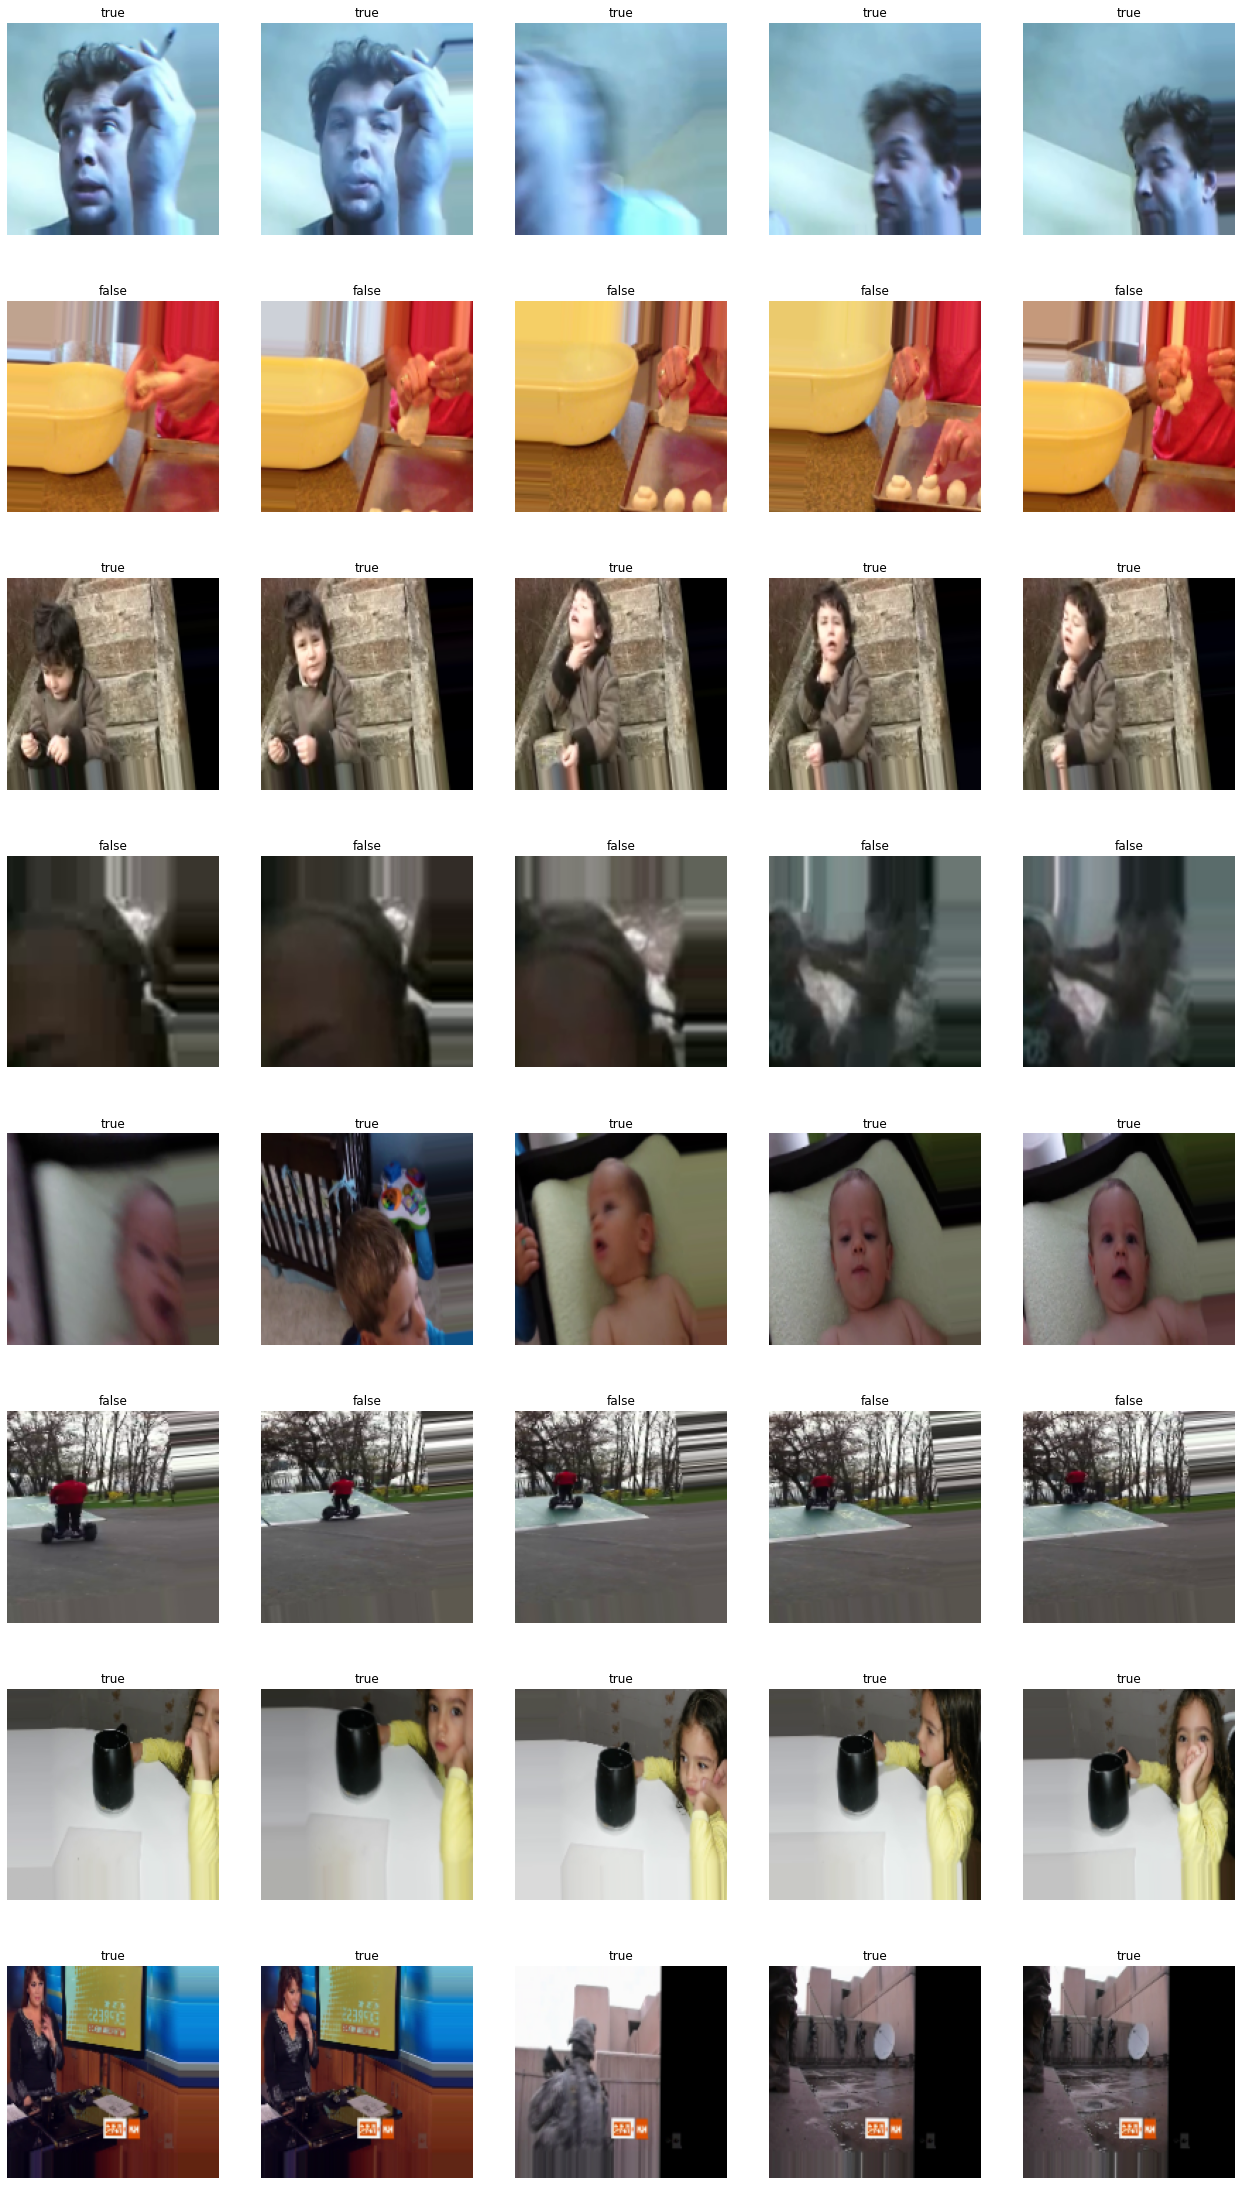

In [23]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [54]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.applications import Xception


In [62]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 5, 2048)           20861480  
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                540928    
_________________________________________________________________
dense_33 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)              

In [63]:
from keras.optimizers import Adam

optimizer= Adam(0.0001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

Try 1: split_val=.2, Adam(0.001), steps_per_epoch = 20, epochs=35, validation_steps=10, NBFRAME = 15
, BS = 15. ACCURACY: 72




Try 1: split_val=.2, Adam(0.0001), steps_per_epoch = 20, epochs=30, validation_steps=10, NBFRAME = 5
, BS = 8. ACCURACY: 74.7

try 3: lr = 0.001 LSTM

In [64]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'coughing_Xcep_sub3.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 30, #23 43
                    epochs=30, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/30
23/30 [======================>.......] - ETA: 15s - loss: 0.7129 - accuracy: 0.4326

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.4456

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 90s 3s/step - loss: 0.7090 - accuracy: 0.4473 - val_loss: 0.6874 - val_accuracy: 0.5256
Epoch 2/30
18/30 [=================>............] - ETA: 16s - loss: 0.7186 - accuracy: 0.4585

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - 52s 2s/step - loss: 0.7126 - accuracy: 0.4621 - val_loss: 0.6870 - val_accuracy: 0.5250
Epoch 3/30
10/30 [=========>....................] - ETA: 24s - loss: 0.6797 - accuracy: 0.5502

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - 45s 2s/step - loss: 0.6873 - accuracy: 0.5221 - val_loss: 0.6747 - val_accuracy: 0.6500
Epoch 4/30
 3/30 [==>...........................] - ETA: 15s - loss: 0.6654 - accuracy: 0.6181

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.6005

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 24s 786ms/step - loss: 0.6777 - accuracy: 0.6005 - val_loss: 0.6585 - val_accuracy: 0.7342
Epoch 5/30
30/30 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.6228

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 23s 755ms/step - loss: 0.6613 - accuracy: 0.6228 - val_loss: 0.6347 - val_accuracy: 0.7468
Epoch 6/30
 6/30 [=====>........................] - ETA: 5s - loss: 0.6696 - accuracy: 0.6309

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6411 - accuracy: 0.7167

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 19s 641ms/step - loss: 0.6406 - accuracy: 0.7178 - val_loss: 0.5694 - val_accuracy: 0.8734
Epoch 7/30
30/30 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7844

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 17s 589ms/step - loss: 0.5780 - accuracy: 0.7852 - val_loss: 0.5441 - val_accuracy: 0.7468
Epoch 8/30
30/30 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.8108

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 10s 343ms/step - loss: 0.5464 - accuracy: 0.8106 - val_loss: 0.4583 - val_accuracy: 0.8608
Epoch 9/30
 1/30 [>.............................] - ETA: 9s - loss: 0.6221 - accuracy: 0.6250

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7489

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 277ms/step - loss: 0.5436 - accuracy: 0.7502 - val_loss: 0.4167 - val_accuracy: 0.8987
Epoch 10/30
30/30 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8003

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 9s 300ms/step - loss: 0.4402 - accuracy: 0.8008 - val_loss: 0.4232 - val_accuracy: 0.8462
Epoch 11/30
30/30 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.7597

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 207ms/step - loss: 0.4922 - accuracy: 0.7610 - val_loss: 0.5164 - val_accuracy: 0.7722
Epoch 12/30
 2/30 [=>............................] - ETA: 4s - loss: 0.5640 - accuracy: 0.7812

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 204ms/step - loss: 0.4772 - accuracy: 0.7642 - val_loss: 0.4987 - val_accuracy: 0.8250
Epoch 13/30
29/30 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.8269

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8272

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 266ms/step - loss: 0.4522 - accuracy: 0.8275 - val_loss: 0.4465 - val_accuracy: 0.8228
Epoch 14/30
19/30 [==================>...........] - ETA: 1s - loss: 0.3775 - accuracy: 0.8137

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8013

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 201ms/step - loss: 0.3918 - accuracy: 0.8010 - val_loss: 0.3457 - val_accuracy: 0.8861
Epoch 15/30
28/30 [===========================>..] - ETA: 0s - loss: 0.4561 - accuracy: 0.7949

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 204ms/step - loss: 0.4523 - accuracy: 0.7994 - val_loss: 0.4660 - val_accuracy: 0.8000
Epoch 16/30
30/30 [==============================] - 6s 194ms/step - loss: 0.4304 - accuracy: 0.8566 - val_loss: 0.4050 - val_accuracy: 0.8250
Epoch 17/30
30/30 [==============================] - 6s 193ms/step - loss: 0.3959 - accuracy: 0.8529 - val_loss: 0.4817 - val_accuracy: 0.8000
Epoch 18/30
30/30 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8128

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 193ms/step - loss: 0.3883 - accuracy: 0.8137 - val_loss: 0.4202 - val_accuracy: 0.8228
Epoch 19/30
30/30 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7611

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 195ms/step - loss: 0.4698 - accuracy: 0.7627 - val_loss: 0.4753 - val_accuracy: 0.7848
Epoch 20/30
11/30 [==========>...................] - ETA: 3s - loss: 0.3549 - accuracy: 0.8654

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 198ms/step - loss: 0.3667 - accuracy: 0.8459 - val_loss: 0.4424 - val_accuracy: 0.8000
Epoch 21/30
30/30 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8312

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 196ms/step - loss: 0.3938 - accuracy: 0.8311 - val_loss: 0.4768 - val_accuracy: 0.7949
Epoch 22/30
 7/30 [======>.......................] - ETA: 4s - loss: 0.3695 - accuracy: 0.8850

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 196ms/step - loss: 0.3471 - accuracy: 0.8784 - val_loss: 0.3073 - val_accuracy: 0.8875
Epoch 23/30
27/30 [==========================>...] - ETA: 0s - loss: 0.3210 - accuracy: 0.8976

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8983

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 203ms/step - loss: 0.3169 - accuracy: 0.8986 - val_loss: 0.5427 - val_accuracy: 0.7875
Epoch 24/30
30/30 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8271

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 201ms/step - loss: 0.4312 - accuracy: 0.8264 - val_loss: 0.5478 - val_accuracy: 0.7722
Epoch 25/30
30/30 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8250

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 197ms/step - loss: 0.3977 - accuracy: 0.8254 - val_loss: 0.3900 - val_accuracy: 0.8101
Epoch 26/30
 7/30 [======>.......................] - ETA: 4s - loss: 0.3560 - accuracy: 0.8325

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/false/not coughing.415.mp4, 0 total, 0 extracted


 9/30 [========>.....................] - ETA: 3s - loss: 0.3611 - accuracy: 0.8316

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.269.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8459

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 201ms/step - loss: 0.3719 - accuracy: 0.8460 - val_loss: 0.5169 - val_accuracy: 0.7821
Epoch 27/30
30/30 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9184

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.361.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 202ms/step - loss: 0.2682 - accuracy: 0.9169 - val_loss: 0.5103 - val_accuracy: 0.7595
Epoch 28/30
30/30 [==============================] - 6s 199ms/step - loss: 0.3372 - accuracy: 0.8665 - val_loss: 0.6308 - val_accuracy: 0.7375
Epoch 29/30
30/30 [==============================] - 6s 200ms/step - loss: 0.3782 - accuracy: 0.8606 - val_loss: 0.4722 - val_accuracy: 0.7875
Epoch 30/30
30/30 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8529

Frame count is not OK for video /content/coughvideos/content/kinetics700/train/true/coughing.189.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 200ms/step - loss: 0.3908 - accuracy: 0.8532 - val_loss: 0.4747 - val_accuracy: 0.7468


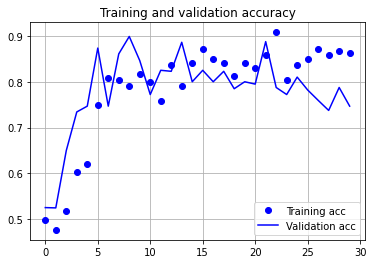

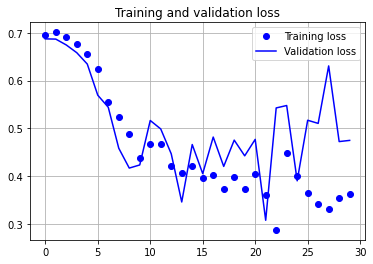

In [65]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [66]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8
glob_pattern='/content/coughvideos/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 87 files for train


In [67]:
model.evaluate(test)

 7/10 [====================>.........] - ETA: 6s - loss: 0.3502 - accuracy: 0.8571

Frame count is not OK for video /content/coughvideos/content/kinetics700/test/true/coughing.40.mp4, 0 total, 0 extracted


10/10 [==============================] - 20s 2s/step - loss: 0.3880 - accuracy: 0.8228


[0.38795992732048035, 0.8227847814559937]

In [68]:
!cp -a '/content/coughing_Xcep_sub3.h5' '/content/drive/MyDrive/Colab Notebooks/Submission 3'